# Pollen NER+RE Pipeline Notebook (May 2025)
# Описание: данный ноутбук реализует полный пайплайн обучения и оценки модели Token Classification (NER+RE) на домене сезонных аллергий.

# **PollenNER** — извлечения сущностей для анализа сообщений Пыльца Club

---




## Заказчик

[Пыльца Club](https://pollen.club/) — краудсорсинговый сервис для людей с пыльцевой аллергией. Платформа объединяет тысячи пользователей, информируя их о текущем уровне аллергенов в воздухе и рисках для здоровья. Данные о концентрации пыльцевых частиц и прогнозах доступны через веб-интерфейс и мобильное приложение, что помогает планировать активность и корректировать терапию.



## Исполнитель



[Мельник Даниил](https://github.com/DanielNRU/)



---



## Описание проекта



Цель — создать и обучить NLP-систему, способную извлекать из пользовательских сообщений ключевую информацию о:



* **Топонимах**

* **Симптомах**

* **Медицинских препаратах**

* **Аллергенах**



---



## Задачи



1. **Подготовка и разметка данных**



 * Загрузка исторических сообщений пользователей

 * Очистка и нормализация текста

 * Аннотирование сущностей в Label Studio

 * Формирование тренировочной и тестовой выборок



2. **Разработка NER-модуля**



 * Использование предобученной модели **DeepPavlov/rubert-base-cased**

 * Активное обучение для оптимального расширения аннотаций

 * Оценка неопределённости для отбора самых информативных примеров

 * PEFT и LoRA для экономии ресурсов при тонкой настройке



3. **Построение RE-модуля**



 * Модель для классификации отношений между сущностями

 * Балансировка классов, оптимизация метрик качества

 * Интеграция в единый пайплайн с NER-модулем



4. **Тестирование и внедрение**



 * Валидация на тестовой выборке

 * Анализ ошибок и доработка сложных кейсов



---



## Технологический стек



* **Языки и библиотеки**: Python, Pandas, NumPy, scikit-learn

* **ML-фреймворки**: PyTorch, Transformers (Hugging Face), PEFT (LoRA)

* **Разметка**: Label Studio

* **Подходы**: Active Learning, Parameter-Efficient Fine-Tuning



---

## Импорты библиотек

In [ ]:
# Стандартные библиотеки Python
import os
import json
import random
import re
import time
import warnings
from collections import Counter
from typing import List, Dict, Optional

# Научные вычисления и обработка данных
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
import multiprocessing
from joblib import parallel_backend

# Hugging Face и трансформеры
from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForTokenClassification,
    Trainer, TrainingArguments, DataCollatorForTokenClassification,
    EarlyStoppingCallback, AutoModelForSequenceClassification,
    AutoConfig
)
from peft import LoraConfig, get_peft_model

# Внешние API и сервисы
import requests
from label_studio_sdk.client import LabelStudio
from dotenv import load_dotenv
import evaluate

## Настройка окружения и константы

In [ ]:
SEED = 42
RANDOM_STATE = 42
LABEL_CONFIG = '''<View>
  <Labels name="label" toName="text">
    <Label value="TOPONYM" background="#ff0d00"/>
    <Label value="MEDICINE" background="#022bf7"/>
    <Label value="SYMPTOM" background="#ffd500"/>
    <Label value="ALLERGEN" background="#00ff55"/>
    <Label value="BODY_PART" background="#ff00ff"/>
  </Labels>

  <Relations>
    <Relation value="has_symptom" />
    <Relation value="has_medicine" />
  </Relations>

  <Text name="text" value="$text" granularity="word"/>
</View>'''

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

In [ ]:
n_jobs = max(1, multiprocessing.cpu_count() - 1)
os.environ['LOKY_MAX_CPU_COUNT'] = str(n_jobs)

# Подавляем лишние предупреждения, чтобы не засорять вывод.
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', message='No label_names provided for model class')
warnings.filterwarnings('ignore', message='Could not find the number of physical cores')

# Загружаем переменные окружения из .env файла (токены, URL и т.д.)
load_dotenv()
LS_TOKEN = os.getenv('LS_LEGACY_TOKEN')  # Токен для Label Studio
LS_URL = os.getenv('LS_URL', 'http://localhost:8080')  # URL сервера Label Studio
HF_TOKEN = os.getenv('HUGGINGFACE_HUB_TOKEN')  # Токен для HuggingFace Hub
assert LS_TOKEN and HF_TOKEN, 'Установите LS_LEGACY_TOKEN и HUGGINGFACE_HUB_TOKEN в .env'

# Инициализация клиента для работы с Label Studio через API
ls = LabelStudio(base_url=LS_URL, api_key=LS_TOKEN)

In [ ]:
## Конфигурация меток и токенизатора
# Список всех сущностей, которые мы хотим распознавать.
LABELS = ['TOPONYM', 'MEDICINE', 'SYMPTOM', 'ALLERGEN', 'BODY_PART']
# Словари для преобразования между строковыми и числовыми метками.
LABEL2ID = {'O': 0, **{f'B-{l}': i*2+1 for i, l in enumerate(LABELS)}, **{f'I-{l}': i*2+2 for i, l in enumerate(LABELS)}}
ID2LABEL = {v: k for k, v in LABEL2ID.items()}

TOKENIZER = AutoTokenizer.from_pretrained('DeepPavlov/rubert-base-cased')

# Список размеров обучающих выборок для активного обучения.
sizes = list(range(50, 1501, 50))

# Список допустимых отношений между сущностями для задачи RE.
RE_RELATION_LABELS = ['has_symptom', 'has_medicine']

# Тестовый пример
TEST_EXAMPLES = [
    "В Московской области у меня началась аллергия на пыльцу березы, потекли глаза, нос, принимаю Зиртек и Назонекс. У ребенка в Новокузнецке чешутся глаза, уши и течет нос, врач прописал Кромогексал, Назонекс в нос. В Санкт-Петербурге началось цветение ольхи, сильная реакция, принимаю Эриус, но глаза все равно слезятся.",
]

# Определяем функцию для вычисления метрик
metric = evaluate.load('seqeval')

## Вспомогательные функции

In [ ]:
def bulk_import_via_http(project_id: int, tasks_list: List[Dict], ls_url: str, ls_token: str, chunk_size: int = 100, max_retries: int = 3):
    """
    Импорт списка задач в Label Studio через HTTP-эндпоинт /import.

    Параметры:
    - project_id: ID проекта в Label Studio
    - tasks_list: список задач для импорта
    - ls_url: URL сервера Label Studio
    - ls_token: токен доступа
    - chunk_size: размер чанка для импорта
    - max_retries: максимальное количество попыток при ошибке

    Процесс:
    1. Разбивает список задач на чанки
    2. Отправляет каждый чанк через API
    3. При ошибке делает повторные попытки с экспоненциальной задержкой
    """
    url = f"{ls_url}/api/projects/{project_id}/import"
    headers = {'Authorization': f'Token {ls_token}', 'Content-Type': 'application/json'}
    total = len(tasks_list)

    # Проходим по списку чанков
    for i in range(0, total, chunk_size):
        chunk = tasks_list[i:i + chunk_size]
        start, end = i + 1, min(i + chunk_size, total)

        # Пытаемся отправить с ретрай
        for attempt in range(1, max_retries + 1):
            resp = requests.post(url, headers=headers, json=chunk)
            if resp.ok:
                print(f"Импортировано задач {start}–{end} из {total}")
                break
            print(f"Ошибка импорта {start}–{end}: {resp.status_code}. Попытка {attempt}/{max_retries}")
            if attempt < max_retries:
                time.sleep(2 ** attempt)  # Экспоненциальная задержка
            else:
                print(f"Не удалось импортировать {start}–{end} после {max_retries} попыток.")

def calculate_uncertainty_scores(model, texts, tokenizer, batch_size=8):
    """
    Рассчитывает оценки неопределенности для каждого текста на основе энтропии предсказаний модели.

    Параметры:
    - model: модель для предсказаний
    - texts: список текстов для оценки
    - tokenizer: токенизатор для обработки текстов
    - batch_size: размер батча для обработки

    Возвращает:
    - список оценок неопределенности для каждого текста
    """
    uncertainties = []
    model.eval()
    device = next(model.parameters()).device

    # Обработка текстов батчами
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, padding=True, truncation=True, max_length=512, return_tensors="pt")
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            # Вычисляем вероятности через softmax
            probs = torch.softmax(logits, dim=-1)
            # Рассчитываем энтропию как меру неопределенности
            entropy = -torch.sum(probs * torch.log(probs + 1e-10), dim=-1)
            # Усредняем энтропию по всем токенам в тексте
            avg_entropy = entropy.mean(dim=1)
            uncertainties.extend(avg_entropy.cpu().numpy())

        # Очищаем память GPU
        del outputs, logits, probs, entropy, avg_entropy
        torch.cuda.empty_cache()

    return uncertainties

def select_uncertain_samples(texts, uncertainties, n_samples=50):
    """
    Выбирает n_samples текстов с наибольшей неопределенностью.
    """
    indices = np.argsort(uncertainties)[-n_samples:]
    selected_texts = [texts[i] for i in indices]

    # Статистика
    print(f"\nВыбрано {n_samples} сообщений с оценками неопределенности:")
    print(f"Минимальная неопределенность: {uncertainties[indices[0]]:.4f}")
    print(f"Максимальная неопределенность: {uncertainties[indices[-1]]:.4f}")
    print(f"Средняя неопределенность: {np.mean(uncertainties[indices]):.4f}")

    return selected_texts


def retry_on_error(func, max_retries=5, delay=2):
    """
    Декоратор для повторных попыток выполнения функции при ошибках.

    Параметры:
    - func: функция для выполнения
    - max_retries: максимальное количество попыток
    - delay: начальная задержка между попытками

    Возвращает:
    - результат выполнения функции или None при неудаче
    """
    def wrapper(*args, **kwargs):
        for attempt in range(max_retries):
            try:
                return func(*args, **kwargs)
            except Exception as e:
                if attempt == max_retries - 1:
                    raise e
                print(f"Ошибка при выполнении {func.__name__}: {str(e)}. Попытка {attempt + 1}/{max_retries}")
                time.sleep(delay * (2 ** attempt))  # Экспоненциальная задержка
        return None
    return wrapper

@retry_on_error
def create_task(ls_client, project_id, text, text_id):
    """
    Создание задачи в Label Studio с повторными попытками.
    """
    return ls_client.tasks.create(
        project=project_id,
        data={
            'text': text,
            'meta': {
                'id': str(text_id)
            }
        }
    )

@retry_on_error
def delete_task(ls_client, task_id):
    """
    Удаление задачи в Label Studio с повторными попытками.
    """
    return ls_client.tasks.delete(task_id)

@retry_on_error
def get_project_tasks(ls_client, project_id):
    """
    Получение списка задач проекта с повторными попытками.
    """
    return list(ls_client.tasks.list(project=project_id, fields=['data', 'is_labeled']))

@retry_on_error
def export_project(ls_client, project_id):
    """
    Экспорт проекта с повторными попытками.
    """
    resp = requests.get(
        f"{LS_URL}/api/projects/{project_id}/export?exportType=JSON&download_all_tasks=true",
        headers={'Authorization': f'Token {LS_TOKEN}'}
    )
    resp.raise_for_status()
    return resp.json()

@retry_on_error
def get_or_create_project(ls_client, title, label_config):
    """
    Получение существующего проекта или создание нового с повторными попытками.
    """
    try:
        proj = next((p for p in ls_client.projects.list() if p.title == title), None)
        if not proj:
            proj = ls_client.projects.create(title=title, label_config=label_config)
            print(f"Создан проект '{title}' (ID={proj.id})")
        return proj
    except Exception as e:
        print(f"Ошибка при работе с проектом '{title}': {str(e)}")
        raise

def ensure_project(texts_with_ids, title, export_path, import_prev_json=None):
    """
    Убеждаемся, что в Label Studio есть проект с нужными текстами.

    Параметры:
    - texts_with_ids: список кортежей (id, text)
    - title: название проекта
    - export_path: путь для сохранения экспортированных данных
    - import_prev_json: путь к файлу с предыдущими аннотациями

    Процесс:
    1. Проверяет существование проекта
    2. Создает новый или использует существующий
    3. Импортирует тексты и аннотации
    4. Экспортирует размеченные данные

    Возвращает:
    - список примеров с аннотациями
    """
    # Находим или создаём проект
    proj = get_or_create_project(ls, title, LABEL_CONFIG)

    # Получаем таски с повторными попытками
    tasks = get_project_tasks(ls, proj.id)

    # Если число совпадает
    if len(tasks) == len(texts_with_ids):
        labeled = sum(t.is_labeled for t in tasks)
        if labeled == len(texts_with_ids):
            print(f"Все {len(texts_with_ids)} задач размечены в '{title}', экспорт")
            data = export_project(ls, proj.id)
            with open(export_path, 'w', encoding='utf-8') as f:
                json.dump(data, f, ensure_ascii=False, indent=2)
            examples = []
            # Парсим аннотации в нужный формат
            for item in data:
                tags = []
                for ann in item.get('annotations', []):
                    for r in ann.get('result', []):
                        v = r.get('value')
                        if v and isinstance(v, dict) and 'start' in v and 'end' in v and 'labels' in v:
                            tags.append({'start': v['start'], 'end': v['end'], 'label': v['labels'][0]})
                examples.append({'text': item['data']['text'], 'tags': tags})
            print(f"Экспортировано {len(examples)} примеров в {export_path}")
            return examples
        # Если есть неразмеченные — ждём
        print(f"В '{title}' размечено {labeled}/{len(texts_with_ids)}. Заверши разметку.")
        input("Нажми Enter после разметки...")
        return ensure_project(texts_with_ids, title, export_path, import_prev_json)

    # Иначе — удаляем и создаём заново
    if tasks:
        for t in tasks:
            delete_task(ls, t.id)
        print(f"Очистили {len(tasks)} задач в '{title}'")

    existing = []
    # Импорт предыдущих аннотаций, если есть
    if import_prev_json and os.path.exists(import_prev_json):
        prev = json.load(open(import_prev_json, 'r', encoding='utf-8'))
        bulk_import_via_http(proj.id, prev, LS_URL, LS_TOKEN, chunk_size=100)
        existing = [i['data']['text'] for i in prev]

    # Создаём новые таски для оставшихся текстов
    for text_id, text in texts_with_ids:
        if text not in existing:
            create_task(ls, proj.id, text, text_id)

    print(f"Созданы {len(texts_with_ids) - len(existing)} новых задач в '{title}'")
    input(f"Разметь их и нажми Enter...")

    # Экспорт и разбираем аннотации
    data = export_project(ls, proj.id)
    with open(export_path, 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=2)

    examples = []
    for item in data:
        tags = []
        for ann in item.get('annotations', []):
            for r in ann.get('result', []):
                v = r.get('value')
                if v and isinstance(v, dict) and 'start' in v and 'end' in v and 'labels' in v:
                    tags.append({'start': v['start'], 'end': v['end'], 'label': v['labels'][0]})
        examples.append({'text': item['data']['text'], 'tags': tags})

    print(f"Экспортировано {len(examples)} примеров в {export_path}")
    return examples

def align_labels(example):
    """
    Привязывает аннотации к токенам текста.

    Параметры:
    - example: пример с текстом и аннотациями

    Возвращает:
    - список ID меток для каждого токена
    """
    tok = TOKENIZER(example['text'], return_offsets_mapping=True, truncation=True, max_length=512)
    labels = ['O'] * len(tok['offset_mapping'])

    # Для каждой аннотации находим соответствующие токены
    for tag in example.get('tags', []):
        for i, (s, e) in enumerate(tok['offset_mapping']):
            if s >= tag['start'] and e <= tag['end']:
                # B- для начала сущности, I- для продолжения
                labels[i] = ('B-' if s == tag['start'] else 'I-') + tag['label']

    return [LABEL2ID[l] for l in labels]

def to_hf_dataset(examples):
    """
    Преобразует примеры в формат HuggingFace Dataset.

    Параметры:
    - examples: список примеров с текстами и аннотациями

    Возвращает:
    - датасет в формате HuggingFace
    - коллатор для батчей
    - список текстов
    """
    if not examples: return None, None, []

    # Преобразуем в DataFrame
    df = pd.DataFrame(examples)
    ds = Dataset.from_pandas(df)

    # Сохраняем тексты для последующего анализа
    texts = df['text'].tolist()

    def fn(ex):
        # Токенизация и выравнивание меток
        tok = TOKENIZER(ex['text'], truncation=True, padding='max_length', max_length=512)
        aligned = align_labels(ex)
        tok['labels'] = aligned + [-100] * (512 - len(aligned))  # -100 для padding
        return tok

    ds = ds.map(fn, batched=False, remove_columns=['text','tags'])
    return ds, DataCollatorForTokenClassification(TOKENIZER), texts

def update_remaining_dataset(remaining_df, json_file):
    """
    Обновляет оставшийся датасет, удаляя из него сообщения, которые были размечены.
    Args:
        remaining_df: DataFrame с оставшимися сообщениями
        json_file: путь к JSON файлу с размеченными данными
    Returns:
        Обновленный DataFrame с оставшимися сообщениями
    """
    # Удаляем все print, связанные с размером датасета и совпадениями
    # Загружаем размеченные данные
    with open(json_file, 'r', encoding='utf-8') as f:
        labeled_data = json.load(f)
    # Получаем ID сообщений из JSON файла
    labeled_ids = []
    for item in labeled_data:
        if 'data' in item and 'meta' in item['data'] and 'id' in item['data']['meta']:
            labeled_ids.append(str(item['data']['meta']['id']))
    if labeled_ids:
        # Проверяем, есть ли совпадения ID
        matching_ids = remaining_df.index.astype(str).isin(labeled_ids)
        # Удаляем строки, где индекс совпадает с ID из JSON
        remaining_df = remaining_df[~remaining_df.index.astype(str).isin(labeled_ids)]
    return remaining_df

def compute_metrics(p):
    """
    Вычисляет метрики для оценки модели NER.
    """
    preds = p.predictions.argmax(-1)
    refs, hyps = [], []
    for pr, gt in zip(preds, p.label_ids):
        r_seq, h_seq = [], []
        for pi, gi in zip(pr, gt):
            if gi == -100:
                continue
            r_seq.append(ID2LABEL[gi])
            h_seq.append(ID2LABEL[pi])
        refs.append(r_seq)
        hyps.append(h_seq)
    out = metric.compute(predictions=hyps, references=refs)
    return {
        'precision': out['overall_precision'],
        'recall': out['overall_recall'],
        'f1': out['overall_f1']
    }

def predict_entities(text: str, model, tokenizer, id2label: Dict[int, str]) -> List[Dict]:
    """
    Извлекает именованные сущности из текста с помощью обученной модели.

    Args:
        text (str): Входной текст для анализа
        model: Обученная модель NER
        tokenizer: Токенизатор для обработки текста
        id2label (Dict[int, str]): Словарь для преобразования ID в метки

    Returns:
        List[Dict]: Список словарей с найденными сущностями в формате:
            [{'text': 'текст сущности', 'label': 'тип сущности', 'start': начало, 'end': конец}]
    """
    # Определяем устройство для вычислений (GPU/CPU)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Токенизация текста с сохранением маппинга позиций
    inputs = tokenizer(
        text,
        return_tensors="pt",
        return_offsets_mapping=True,
        truncation=True,
        max_length=512
    )
    offset_mapping = inputs.pop('offset_mapping')[0]

    # Перенос входных данных на нужное устройство
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Получение предсказаний модели
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = outputs.logits.argmax(-1)[0]

    # Перенос предсказаний обратно на CPU для обработки
    predictions = predictions.cpu()

    # Обработка предсказаний и сбор сущностей
    entities = []
    current_entity = None

    # Проходим по всем токенам и их позициям
    for pred, (start, end) in zip(predictions, offset_mapping):
        # Пропускаем специальные токены (CLS, SEP, PAD)
        if start == 0 and end == 0:
            continue

        # Получаем метку для текущего токена
        label = id2label[pred.item()]

        if label.startswith('B-'):
            # Если встретили начало новой сущности
            if current_entity:
                # Сохраняем предыдущую сущность
                entities.append(current_entity)
            # Создаем новую сущность
            current_entity = {
                'text': text[start:end],
                'label': label[2:],  # Убираем префикс B-
                'start': start,
                'end': end
            }
        elif label.startswith('I-') and current_entity and label[2:] == current_entity['label']:
            # Продолжаем текущую сущность
            current_entity['text'] += text[start:end]
            current_entity['end'] = end
        else:
            # Если встретили токен вне сущности
            if current_entity:
                # Сохраняем текущую сущность
                entities.append(current_entity)
                current_entity = None

    # Добавляем последнюю сущность, если она есть
    if current_entity:
        entities.append(current_entity)

    return entities

def test_model_on_example(model, tokenizer, text):
    """
    Тестирует модель на одном примере и выводит результаты разметки в унифицированном формате.
    Для NER модели выводит все определенные сущности.
    Для RE модели выводит все сущности, но для SYMPTOM использует только те, что получены из has_symptom.
    """
    print(f"\nТестовый пример:")
    print(f"Текст: {text}")

    # Получаем предсказанные сущности
    entities = predict_entities(text, model, tokenizer, ID2LABEL)

    # Группируем сущности по типу
    ent_by_type = {label: [] for label in LABELS}
    for ent in entities:
        if ent['label'] in ent_by_type:
            ent_by_type[ent['label']].append(ent['text'])

    # Выводим результаты NER
    print("\n[NER] Результаты анализа:")
    for label in LABELS:
        if ent_by_type[label]:
            print(f"{label}: {', '.join(ent_by_type[label])}")
        else:
            print(f"{label}: не найдено")

    # Получаем отношения для извлечения симптомов
    relations = []
    if hasattr(model, 're_model'):  # Если есть RE модель
        entities, relations = infer_ner_re_on_text(text, model, model.re_model, tokenizer, ID2LABEL, model.rel_id2label)

        # Собираем симптомы из отношений has_symptom
        symptoms_from_relations = []
        for rel in relations:
            if rel['relation'] == 'has_symptom':
                symptoms_from_relations.append(rel['tail']['text'])

        # Группируем все сущности по типу
        re_ent_by_type = {label: [] for label in LABELS}
        for ent in entities:
            if ent['label'] in re_ent_by_type:
                re_ent_by_type[ent['label']].append(ent['text'])

        # Выводим результаты RE
        print("\n[RE] Результаты анализа:")
        for label in LABELS:
            if label == 'SYMPTOM':
                # Для SYMPTOM используем только те, что из has_symptom
                if symptoms_from_relations:
                    print(f"{label}: {', '.join(symptoms_from_relations)}")
                else:
                    print(f"{label}: не найдено")
            else:
                # Для остальных сущностей используем все найденные
                if re_ent_by_type[label]:
                    print(f"{label}: {', '.join(re_ent_by_type[label])}")
                else:
                    print(f"{label}: не найдено")

In [ ]:
def analyze_class_distribution(model, tokenizer, texts, save_path='class_distribution.png'):
    """
    Анализирует и визуализирует распределение классов в наборе текстов.

    Параметры:
    - model: обученная модель
    - tokenizer: токенизатор
    - texts: список текстов для анализа
    - save_path: путь для сохранения графика
    """
    # Получаем распределение классов
    distribution = calculate_class_distribution(texts, tokenizer, model)

    if not distribution:
        print("Не удалось получить распределение классов")
        return

    # Создаем DataFrame для визуализации
    df = pd.DataFrame({
        'Класс': list(distribution.keys()),
        'Доля': list(distribution.values())
    })

    # Сортируем по доле
    df = df.sort_values('Доля', ascending=False)

    # Создаем график
    plt.figure(figsize=(12, 6))
    sns.set_style("whitegrid")

    # Основной график распределения
    ax = sns.barplot(data=df, x='Класс', y='Доля')

    # Настраиваем внешний вид
    plt.title('Распределение классов в датасете', pad=20)
    plt.xlabel('Класс')
    plt.ylabel('Доля')
    plt.xticks(rotation=45)

    # Добавляем значения над столбцами
    for i, v in enumerate(df['Доля']):
        ax.text(i, v, f'{v:.3f}', ha='center', va='bottom')

    # Добавляем информацию о балансе
    balance_score = calculate_class_balance_score(distribution)
    plt.figtext(0.02, 0.02, f'Оценка баланса классов: {balance_score:.3f}',
                fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()

    # Выводим статистику
    print("\nСтатистика распределения классов:")
    print(f"Всего классов: {len(distribution)}")
    print(f"Оценка баланса: {balance_score:.3f}")
    print("\nРаспределение по классам:")
    for label, prob in sorted(distribution.items(), key=lambda x: x[1], reverse=True):
        print(f"- {label}: {prob:.3f}")

def run_cycle(df_path: str, sizes, start_size: Optional[int] = None) -> None:
    """
    Запускает цикл обучения модели NER с активным обучением.

    Args:
        df_path (str): Путь к исходному датасету
        start_size (Optional[int]): Размер выборки, с которой начать обучение
    """
    # Загружаем датасет и создаем копию для оставшихся сообщений
    df = pd.read_csv(df_path, sep=';', index_col=0)
    print(f"Загружен исходный датасет размером {len(df)} сообщений")
    print("Первые 5 строк исходного датасета:")
    print(df.head())

    # Если указан start_size, находим его индекс в списке sizes
    start_index = 0
    if start_size is not None:
        try:
            start_index = sizes.index(start_size)
            print(f"Начинаем с итерации {start_index + 1} (размер выборки {start_size})")
        except ValueError:
            print(f"Ошибка: размер выборки {start_size} не найден в списке допустимых размеров")
            return

    # Проверяем существование тестового проекта
    test_project_title = 'PollenNER TEST'
    test_project = get_or_create_project(ls, test_project_title, LABEL_CONFIG)
    test_tasks = get_project_tasks(ls, test_project.id)

    # Если тестовый проект пустой или не существует, создаем его
    if not test_tasks:
        print("\nСоздание тестового проекта из случайных записей")
        # Выбираем 100 случайных записей с фиксированным seed
        test_df = df.sample(n=100, random_state=SEED)
        test_texts_with_ids = [(idx, text) for idx, text in zip(test_df.index, test_df['text'])]

        # Создаем задачи в Label Studio
        for text_id, text in test_texts_with_ids:
            create_task(ls, test_project.id, text, text_id)

        print(f"Создано {len(test_texts_with_ids)} тестовых задач")
        print("Пожалуйста, разместите тестовые данные в Label Studio")
        input("Нажмите Enter после завершения разметки...")

        # Экспортируем размеченные данные
        test_data = export_project(ls, test_project.id)
        with open('PollenNER_TEST.json', 'w', encoding='utf-8') as f:
            json.dump(test_data, f, ensure_ascii=False, indent=2)

        # Преобразуем данные в формат для обучения
        test_ex = []
        for item in test_data:
            tags = []
            for ann in item.get('annotations', []):
                for r in ann.get('result', []):
                    v = r.get('value')
                    if v and isinstance(v, dict) and 'start' in v and 'end' in v and 'labels' in v:
                        tags.append({'start': v['start'], 'end': v['end'], 'label': v['labels'][0]})
            test_ex.append({'text': item['data']['text'], 'tags': tags})

        # Создаем тестовый датасет
        test_ds, _, _ = to_hf_dataset(test_ex)

        # Обновляем оставшийся датасет
        test_ids = [str(item['data']['meta']['id']) for item in test_data]
        remaining_df = df[~df.index.astype(str).isin(test_ids)]
        print(f"Размер оставшегося датасета после создания тестового: {len(remaining_df)}")
    else:
        print("\nТестовый проект уже существует, загружаем данные")
        # Загружаем существующие тестовые данные
        with open('PollenNER_TEST.json', 'r', encoding='utf-8') as f:
            test_data = json.load(f)

        # Преобразуем данные в формат для обучения
        test_ex = []
        for item in test_data:
            tags = []
            for ann in item.get('annotations', []):
                for r in ann.get('result', []):
                    v = r.get('value')
                    if v and isinstance(v, dict) and 'start' in v and 'end' in v and 'labels' in v:
                        tags.append({'start': v['start'], 'end': v['end'], 'label': v['labels'][0]})
            test_ex.append({'text': item['data']['text'], 'tags': tags})

        test_ds, _, _ = to_hf_dataset(test_ex)
        test_ids = [str(item['data']['meta']['id']) for item in test_data]
        remaining_df = df[~df.index.astype(str).isin(test_ids)]
        print(f"Размер оставшегося датасета: {len(remaining_df)}")

    results = []

    # --- Инициализация базовой модели с dropout через конфиг ---
    config = AutoConfig.from_pretrained(
        'DeepPavlov/rubert-base-cased',
        hidden_dropout_prob=0.3,  # Dropout для регуляризации
        attention_probs_dropout_prob=0.3,  # Dropout на внимании
        id2label=ID2LABEL,
        label2id=LABEL2ID
    )
    base_model = AutoModelForTokenClassification.from_pretrained('DeepPavlov/rubert-base-cased', config=config)

    # Если начинаем не с начала, загружаем последнюю обученную модель
    if start_index > 0:
        prev_size = sizes[start_index - 1]
        model_path = f'models/pollen_ner_{prev_size}'
        if os.path.exists(model_path):
            print(f"Загружаем модель из {model_path}")
            model = get_peft_model(base_model, LoraConfig(task_type='TOKEN_CLS', r=16, lora_alpha=32, lora_dropout=0.1))
            model.load_adapter(model_path, adapter_name="default")
            # Перемещаем модель на GPU, если доступен
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            model = model.to(device)
            print(f"Модель перемещена на {device}")
        else:
            print(f"Ошибка: модель {model_path} не найдена")
            return
    else:
        model = get_peft_model(base_model, LoraConfig(task_type='TOKEN_CLS', r=16, lora_alpha=32, lora_dropout=0.1))
        # Перемещаем модель на GPU, если доступен
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = model.to(device)
        print(f"Модель перемещена на {device}")

    # Продолжаем с указанной итерации
    for i, size in enumerate(sizes[start_index:], start_index):
        print(f"\n[NER] Начинаем итерацию с размером выборки {size}")

        # Проверяем наличие существующего проекта для текущего размера
        title = f'PollenNER TRAIN {size}'
        export_file = f'PollenNER_TRAIN_{size}.json'

        # Проверяем, существует ли проект и все ли задачи размечены
        proj = get_or_create_project(ls, title, LABEL_CONFIG)
        tasks = get_project_tasks(ls, proj.id)

        if tasks and all(t.is_labeled for t in tasks):
            print(f"Найден существующий размеченный проект для размера {size}")
            # Экспортируем размеченные данные
            data = export_project(ls, proj.id)
            with open(export_file, 'w', encoding='utf-8') as f:
                json.dump(data, f, ensure_ascii=False, indent=2)

            # Преобразуем данные в формат для обучения
            train_ex = []
            for item in data:
                tags = []
                for ann in item.get('annotations', []):
                    for r in ann.get('result', []):
                        v = r.get('value')
                        if v and isinstance(v, dict) and 'start' in v and 'end' in v and 'labels' in v:
                            tags.append({'start': v['start'], 'end': v['end'], 'label': v['labels'][0]})
                train_ex.append({'text': item['data']['text'], 'tags': tags})
        else:
            # Если это первая итерация и проект пустой, создаем его с нуля
            if i == start_index and not tasks:
                print(f"\nСоздание первого тренировочного проекта с размером {size}")
                # Выбираем случайные записи с фиксированным seed
                train_df = remaining_df.sample(n=size, random_state=SEED)
                train_texts_with_ids = [(idx, text) for idx, text in zip(train_df.index, train_df['text'])]

                # Создаем задачи в Label Studio
                for text_id, text in train_texts_with_ids:
                    create_task(ls, proj.id, text, text_id)

                print(f"Создано {len(train_texts_with_ids)} тренировочных задач")
                print("Пожалуйста, разместите тренировочные данные в Label Studio")
                input("Нажмите Enter после завершения разметки...")

                # Экспортируем размеченные данные
                data = export_project(ls, proj.id)
                with open(export_file, 'w', encoding='utf-8') as f:
                    json.dump(data, f, ensure_ascii=False, indent=2)

                # Преобразуем данные в формат для обучения
                train_ex = []
                for item in data:
                    tags = []
                    for ann in item.get('annotations', []):
                        for r in ann.get('result', []):
                            v = r.get('value')
                            if v and isinstance(v, dict) and 'start' in v and 'end' in v and 'labels' in v:
                                tags.append({'start': v['start'], 'end': v['end'], 'label': v['labels'][0]})
                    train_ex.append({'text': item['data']['text'], 'tags': tags})
            else:
                # Загружаем размеченные данные из предыдущей итерации
                prev_size = sizes[i-1] if i > 0 else 0
                prev_json = f'PollenNER_TRAIN_{prev_size}.json'
                if os.path.exists(prev_json):
                    print(f"Загружаем размеченные данные из {prev_json}")
                    with open(prev_json, 'r', encoding='utf-8') as f:
                        prev_data = json.load(f)

                    # Создаем список задач для импорта
                    tasks_list = []

                    # Добавляем размеченные данные из предыдущей итерации
                    for item in prev_data:
                        tasks_list.append({
                            'data': {
                                'text': item['data']['text'],
                                'meta': {
                                    'id': item['data']['meta']['id']
                                }
                            },
                            'annotations': item.get('annotations', [])
                        })

                    # Импортируем размеченные данные
                    if tasks_list:
                        print(f"Импортируем {len(tasks_list)} размеченных сообщений из предыдущей итерации")
                        bulk_import_via_http(proj.id, tasks_list, LS_URL, LS_TOKEN)

                # Выбираем наименее уверенные примеры из оставшегося датасета
                if len(remaining_df) > 0:
                    # Получаем оценки неопределенности для всех оставшихся сообщений
                    uncertainties = calculate_uncertainty_scores(model, remaining_df['text'].tolist(), TOKENIZER)

                    # Выбираем сообщения с наивысшей неопределенностью
                    # Количество новых примеров = текущий размер - предыдущий размер
                    n_new_samples = size - prev_size
                    selected_indices = select_samples_improved(
                        model,
                        remaining_df['text'].tolist(),
                        TOKENIZER,
                        n_samples=n_new_samples,
                        remaining_texts=remaining_df['text'].tolist(),
                        current_iteration=i
                    )

                    # Получаем выбранные сообщения с их ID
                    selected_df = remaining_df.iloc[selected_indices]
                    train_texts = [(idx, text) for idx, text in zip(selected_df.index, selected_df['text'])]

                    # Добавляем новые сообщения в проект
                    print(f"Добавляем {len(train_texts)} новых сообщений для разметки")
                    for text_id, text in train_texts:
                        create_task(ls, proj.id, text, text_id)

                    # Ждем разметки новых данных
                    print(f"\nРазметьте {len(train_texts)} новых сообщений в Label Studio")
                    input("Нажмите Enter после завершения разметки...")

                    # Экспортируем все размеченные данные
                    data = export_project(ls, proj.id)
                    with open(export_file, 'w', encoding='utf-8') as f:
                        json.dump(data, f, ensure_ascii=False, indent=2)

                    # Преобразуем данные в формат для обучения
                    train_ex = []
                    for item in data:
                        tags = []
                        for ann in item.get('annotations', []):
                            for r in ann.get('result', []):
                                v = r.get('value')
                                if v and isinstance(v, dict) and 'start' in v and 'end' in v and 'labels' in v:
                                    tags.append({'start': v['start'], 'end': v['end'], 'label': v['labels'][0]})
                        train_ex.append({'text': item['data']['text'], 'tags': tags})
                else:
                    print("Больше нет доступных сообщений для обучения")
                    break

        # Обновляем оставшийся датасет
        remaining_df = update_remaining_dataset(remaining_df, export_file)

        print(f"После итерации {i+1} осталось {len(remaining_df)} сообщений")

        train_ds, coll, train_texts = to_hf_dataset(train_ex)

        # Настройка аргументов тренировки
        args = TrainingArguments(
            output_dir=f'runs/train_{size}',
            per_device_train_batch_size=8,
            per_device_eval_batch_size=8,
            num_train_epochs=10,
            load_best_model_at_end=True,
            metric_for_best_model='eval_f1',
            greater_is_better=True,
            eval_strategy='epoch',
            save_strategy='epoch',
            save_total_limit=2,
            push_to_hub=True,
            hub_model_id=f'pollen-ner-{size}',
            hub_token=HF_TOKEN,
            no_cuda=not torch.cuda.is_available(),
            weight_decay=0.01  # L2-регуляризация для борьбы с переобучением
        )

        # Создаем trainer
        trainer = Trainer(
            model=model,
            args=args,
            train_dataset=train_ds,
            eval_dataset=test_ds,
            data_collator=coll,
            tokenizer=TOKENIZER,
            compute_metrics=compute_metrics,
            callbacks=[EarlyStoppingCallback(
                early_stopping_patience=2,  # Уменьшено patience для ранней остановки
                early_stopping_threshold=0.001
            )]
        )

        print(f"[NER] Обучение на {size} примерах")
        trainer.train()
        ev = trainer.evaluate()
        print(f"[NER] Результаты: F1 = {ev['eval_f1']:.4f}")

        # Получаем предсказания для тестового набора
        predictions = trainer.predict(test_ds)
        preds = predictions.predictions.argmax(-1)
        labels = predictions.label_ids

        # Подготавливаем списки для эталонных и предсказанных последовательностей
        refs, hyps = [], []
        for pr, gt in zip(preds, labels):
            r_seq, h_seq = [], []
            for pi, gi in zip(pr, gt):
                if gi == -100:
                    continue
                r_seq.append(ID2LABEL[gi])
                h_seq.append(ID2LABEL[pi])
            refs.append(r_seq)
            hyps.append(h_seq)

        # Преобразуем последовательности в плоский формат для classification_report
        flat_refs = []
        flat_hyps = []
        for r_seq, h_seq in zip(refs, hyps):
            flat_refs.extend(r_seq)
            flat_hyps.extend(h_seq)

        # Выводим подробный отчет о классификации
        print("\n[NER] Подробный отчет о классификации:")
        print(classification_report(flat_refs, flat_hyps, digits=4))

        # Сохраняем лучшую модель
        model_save_path = f'models/pollen_ner_{size}'
        os.makedirs(model_save_path, exist_ok=True)
        trainer.save_model(model_save_path)
        print(f"[NER] Модель сохранена в {model_save_path}")

        # --- Сохраняем только лучшую модель NER ---
        best_f1 = -1
        best_model_path = 'models/pollen_ner_best'

        if ev['eval_f1'] > best_f1:
            best_f1 = ev['eval_f1']
            os.makedirs(best_model_path, exist_ok=True)
            trainer.save_model(best_model_path)
            TOKENIZER.save_pretrained(best_model_path)
            print(f"[NER] Лучшая модель за все итерации сохранена в {best_model_path}")

        # Тестируем модель на примерах после каждой итерации
        print("\n[NER] Тестирование модели после обучения:")
        test_model_on_example(model, TOKENIZER, TEST_EXAMPLES[0])

        results.append({'size': size, 'f1': ev['eval_f1']})

        # Загружаем лучшую модель для следующей итерации
        model = get_peft_model(base_model, LoraConfig(task_type='TOKEN_CLS', r=16, lora_alpha=32, lora_dropout=0.1))
        model.load_adapter(model_save_path, adapter_name="default")
        # Перемещаем модель на GPU, если доступен
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = model.to(device)
        print(f"Модель перемещена на {device}")

        # После каждой итерации выводим статистику распределения классов по train_texts
        from collections import Counter
        print(f"\nСтатистика распределения классов в тренировочном датасете после итерации {i+1}:")
        all_labels = []
        for ex in train_texts:
            pass
        # Посчитаем по меткам:
        if 'train_ex' in locals():
            for ex in train_ex:
                for tag in ex.get('tags', []):
                    all_labels.append(tag['label'])
            print(Counter(all_labels))
        else:
            print('Нет данных для подсчёта статистики по меткам.')

    # Визуализация результатов
    plt.figure(figsize=(10, 6))
    sns.set_style("whitegrid")
    results_df = pd.DataFrame(results)
    ax = plt.gca()
    sns.lineplot(data=results_df, x='size', y='f1', marker='o', ax=ax)
    ax.set_title('Зависимость F1 от размера выборки', pad=20)
    ax.set_xlabel('Размер обучающей выборки')
    ax.set_ylabel('F1 Score')
    # Подпись только у максимального значения F1
    max_idx = results_df['f1'].idxmax()
    max_x = results_df.loc[max_idx, 'size']
    max_y = results_df.loc[max_idx, 'f1']
    ax.annotate(f'{max_y:.3f}', (max_x, max_y), textcoords="offset points",
                xytext=(0,10), ha='center', color='red', fontsize=12, fontweight='bold')
    plt.tight_layout()

    # Выводим график на экран
    plt.show()

    # Сохраняем график на диск
    plt.savefig('learning_curve.png', dpi=300, bbox_inches='tight')
    plt.close()

    # Сохраняем финальный оставшийся датасет
    remaining_df.to_csv('remaining_dataset_final.csv', sep=';')
    print(f"\nФинальный оставшийся датасет сохранен в remaining_dataset_final.csv")
    print(f"Размер финального датасета: {len(remaining_df)} сообщений")

    # После цикла обучения NER:
    last_ner_model = model  # Сохраняем последнюю обученную NER-модель

    # Загружаем последнюю сохранённую модель из директории
    last_size = sizes[-1] if start_size is None else sizes[start_index + len(results) - 1]
    model_save_path = f'models/pollen_ner_{last_size}'
    base_model = AutoModelForTokenClassification.from_pretrained('DeepPavlov/rubert-base-cased', id2label=ID2LABEL, label2id=LABEL2ID)
    last_ner_model = get_peft_model(base_model, LoraConfig(task_type='TOKEN_CLS', r=16, lora_alpha=32, lora_dropout=0.1))
    last_ner_model.load_adapter(model_save_path, adapter_name="default")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    last_ner_model = last_ner_model.to(device)
    return last_ner_model

def test_model_on_text(model, tokenizer, text):
    """
    Тестирует модель на новом тексте и выводит результаты разметки.

    Параметры:
    - model: обученная модель
    - tokenizer: токенизатор
    - text: текст для тестирования

    Выводит:
    - разметку текста с выделением найденных сущностей
    """
    model.eval()
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    inputs = {k: v.to(next(model.parameters()).device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        predictions = outputs.logits.argmax(-1)[0]

    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    labels = [ID2LABEL[p.item()] for p in predictions]

    print("\nРезультаты разметки текста:")
    print("-" * 50)
    print(f"Текст: {text}")
    print("\nРазметка:")
    current_entity = None
    current_text = ""

    # Обработка токенов и меток
    for token, label in zip(tokens, labels):
        if token in ["[CLS]", "[SEP]", "[PAD]"]:
            continue
        if label.startswith("B-"):
            if current_entity:
                print(f"{current_entity}: {current_text.strip()}")
            current_entity = label[2:]
            current_text = token.replace("##", "")
        elif label.startswith("I-"):
            current_text += " " + token.replace("##", "")
        else:
            if current_entity:
                print(f"{current_entity}: {current_text.strip()}")
                current_entity = None
                current_text = ""

    if current_entity:
        print(f"{current_entity}: {current_text.strip()}")

def calculate_class_diversity(text, tokenizer, model):
    """
    Рассчитывает разнообразие классов в тексте на основе предсказаний модели.

    Параметры:
    - text: текст для анализа
    - tokenizer: токенизатор
    - model: модель для предсказаний

    Возвращает:
    - количество уникальных классов в тексте
    """
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    inputs = {k: v.to(next(model.parameters()).device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        predictions = outputs.logits.argmax(-1)[0]

    # Собираем уникальные классы (исключая O)
    unique_classes = set()
    for pred in predictions:
        label = ID2LABEL[pred.item()]
        if label != 'O':
            unique_classes.add(label.split('-')[1])  # Убираем B-/I- префикс

    return len(unique_classes)

def calculate_text_diversity(texts, n_clusters=5):
    """
    Рассчитывает разнообразие текстов с помощью кластеризации TF-IDF.

    Параметры:
    - texts: список текстов
    - n_clusters: количество кластеров для кластеризации

    Возвращает:
    - оценку разнообразия текстов (0-1)
    """
    with parallel_backend('loky', n_jobs=n_jobs):
        # Векторизация текстов
        vectorizer = TfidfVectorizer(max_features=1000)
        tfidf_matrix = vectorizer.fit_transform(texts)

        # Кластеризация текстов
        kmeans = KMeans(
            n_clusters=min(n_clusters, len(texts)),
            random_state=42
        )
        clusters = kmeans.fit_predict(tfidf_matrix)

        # Анализ распределения текстов по кластерам
        cluster_counts = Counter(clusters)

        # Нормализация счетчиков для получения оценки разнообразия
        total = len(texts)
        diversity_scores = [1 - (count/total) for count in cluster_counts.values()]

        return np.mean(diversity_scores)

def calculate_class_balance(text, tokenizer, model):
    """
    Рассчитывает баланс классов в тексте.

    Параметры:
    - text: текст для анализа
    - tokenizer: токенизатор
    - model: модель для предсказаний

    Возвращает:
    - нормализованную энтропию распределения классов (0-1)
    """
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    inputs = {k: v.to(next(model.parameters()).device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        predictions = outputs.logits.argmax(-1)[0]

    # Подсчет количества каждого класса
    class_counts = Counter()
    for pred in predictions:
        label = ID2LABEL[pred.item()]
        if label != 'O':
            class_counts[label.split('-')[1]] += 1

    if not class_counts:
        return 0

    # Расчет энтропии распределения классов
    total = sum(class_counts.values())
    probs = [count/total for count in class_counts.values()]
    entropy = -sum(p * np.log(p) for p in probs)

    # Нормализация энтропии
    max_entropy = np.log(len(LABELS))
    return entropy / max_entropy if max_entropy > 0 else 0

def calculate_class_distribution(texts, tokenizer, model):
    """
    Рассчитывает распределение классов в наборе текстов.

    Параметры:
    - texts: список текстов
    - tokenizer: токенизатор
    - model: модель для предсказаний

    Возвращает:
    - словарь с распределением классов
    """
    class_counts = Counter()
    total_tokens = 0

    for text in texts:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
        inputs = {k: v.to(next(model.parameters()).device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)
            predictions = outputs.logits.argmax(-1)[0]

        for pred in predictions:
            label = ID2LABEL[pred.item()]
            if label != 'O':
                class_counts[label.split('-')[1]] += 1
                total_tokens += 1

    return {k: v/total_tokens for k, v in class_counts.items()} if total_tokens > 0 else {}

def calculate_class_balance_score(class_distribution):
    """
    Рассчитывает оценку баланса классов.

    Параметры:
    - class_distribution: распределение классов

    Возвращает:
    - оценку баланса (0-1)
    """
    if not class_distribution:
        return 0

    # Расчет энтропии распределения
    probs = list(class_distribution.values())
    entropy = -sum(p * np.log(p) for p in probs)

    # Нормализация энтропии
    max_entropy = np.log(len(LABELS))
    return entropy / max_entropy if max_entropy > 0 else 0

def select_samples_improved(model, texts, tokenizer, n_samples=50, remaining_texts=None, current_iteration=0):
    """
    Улучшенная стратегия отбора сообщений для активного обучения.
    Учитывает неопределенность модели, разнообразие текстов и баланс классов.

    Параметры:
    - model: текущая модель
    - texts: список текстов для отбора
    - tokenizer: токенизатор
    - n_samples: количество сообщений для отбора
    - remaining_texts: оставшиеся тексты для учета разнообразия
    - current_iteration: текущая итерация обучения

    Возвращает:
    - индексы отобранных сообщений
    """
    # Веса для метрик
    weights = {
        'uncertainty': 0.5,      # Неопределенность модели
        'text_diversity': 0.2,   # Разнообразие текстов
        'class_balance': 0.3     # Баланс классов
    }

    # Получаем оценки неопределенности
    uncertainties = calculate_uncertainty_scores(model, texts, tokenizer)

    # Рассчитываем разнообразие текстов
    n_clusters = min(5, max(2, len(texts) // 10))
    if remaining_texts:
        text_diversity = calculate_text_diversity(texts + remaining_texts, n_clusters=n_clusters)
    else:
        text_diversity = calculate_text_diversity(texts, n_clusters=n_clusters)

    # Рассчитываем текущее распределение классов
    current_distribution = calculate_class_distribution(texts, tokenizer, model)
    class_balance = calculate_class_balance_score(current_distribution)

    # Нормализация неопределенности
    uncertainties = np.array(uncertainties)
    uncertainties = (uncertainties - uncertainties.min()) / (uncertainties.max() - uncertainties.min() + 1e-10)

    # Комбинирование метрик с весами
    combined_scores = (
        weights['uncertainty'] * uncertainties +
        weights['text_diversity'] * text_diversity +
        weights['class_balance'] * class_balance
    )

    # Выбор сообщений с наивысшими комбинированными оценками
    selected_indices = np.argsort(combined_scores)[-n_samples:]

    # Вывод подробной статистики
    print("\nСтатистика отобранных сообщений:")
    print(f"Итерация: {current_iteration}")
    print(f"Веса метрик:")
    for metric, weight in weights.items():
        print(f"- {metric}: {weight:.3f}")
    print(f"Средняя неопределенность: {np.mean(uncertainties[selected_indices]):.4f}")
    print(f"Разнообразие текстов: {text_diversity:.4f}")
    print(f"Баланс классов: {class_balance:.4f}")
    print("\nРаспределение классов:")
    for label, prob in current_distribution.items():
        print(f"- {label}: {prob:.3f}")

    return selected_indices

def analyze_relations_distribution(relations_list):
    """
    Анализирует распределение типов отношений в наборе данных.

    Параметры:
    - relations_list: список отношений

    Возвращает:
    - словарь с распределением типов отношений
    """
    relation_counts = Counter()
    for relations in relations_list:
        for rel in relations:
            relation_counts[rel['relation']] += 1

    total = sum(relation_counts.values())
    return {k: v/total for k, v in relation_counts.items()} if total > 0 else {}

def visualize_relations_distribution(relations_list, save_path='relations_distribution.png'):
    """
    Визуализирует распределение типов отношений.

    Параметры:
    - relations_list: список отношений
    - save_path: путь для сохранения графика
    """
    distribution = analyze_relations_distribution(relations_list)

    if not distribution:
        print("Не удалось получить распределение отношений")
        return

    # Создаем DataFrame для визуализации
    df = pd.DataFrame({
        'Тип отношения': list(distribution.keys()),
        'Доля': list(distribution.values())
    })

    # Сортируем по доле
    df = df.sort_values('Доля', ascending=False)

    # Создаем график
    plt.figure(figsize=(10, 6))
    sns.set_style("whitegrid")

    # Основной график распределения
    ax = sns.barplot(data=df, x='Тип отношения', y='Доля')

    # Настраиваем внешний вид
    plt.title('Распределение типов отношений', pad=20)
    plt.xlabel('Тип отношения')
    plt.ylabel('Доля')
    plt.xticks(rotation=45)

    # Добавляем значения над столбцами
    for i, v in enumerate(df['Доля']):
        ax.text(i, v, f'{v:.3f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()

    # Выводим статистику
    print("\nСтатистика распределения отношений:")
    print(f"Всего типов отношений: {len(distribution)}")
    print("\nРаспределение по типам:")
    for rel_type, prob in sorted(distribution.items(), key=lambda x: x[1], reverse=True):
        print(f"- {rel_type}: {prob:.3f}")

def parse_labelstudio_json(json_path):
    """
    Извлекает сущности и отношения из разметки Label Studio (JSON).
    Поддерживает только отношения из RE_RELATION_LABELS.
    Пропускает примеры без сущностей или с одной сущностью.

    Важно: для RE критично, чтобы id в отношениях (from_id, to_id) совпадали с id сущностей.
    Также важно учитывать направленность отношений (from_id -> to_id).
    """
    results = []
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    for item in data:
        text = item['data']['text']
        ann = item['annotations'][0]['result'] if item['annotations'] and 'result' in item['annotations'][0] else []
        entities = []
        relations = []
        for obj in ann:
            if obj.get('type') == 'labels':
                ent = {
                    'id': obj['id'],
                    'start': obj['value']['start'],
                    'end': obj['value']['end'],
                    'label': obj['value']['labels'][0],
                    'text': obj['value']['text']
                }
                entities.append(ent)
        for obj in ann:
            if obj.get('type') == 'relation':
                if 'labels' in obj:
                    rel_label = obj['labels'][0]
                elif 'label' in obj:
                    rel_label = obj['label']
                else:
                    rel_label = 'unknown_relation'
                if rel_label in RE_RELATION_LABELS:
                    rel = {
                        'from_id': obj['from_id'],
                        'to_id': obj['to_id'],
                        'label': rel_label
                    }
                    relations.append(rel)
        # Пропускаем примеры без сущностей или с одной сущностью
        if len(entities) < 2:
            continue
        results.append({'text': text, 'entities': entities, 'relations': relations})
    return results

def split_sentences(text):
    """
    Разбивает текст на предложения по точкам, восклицательным и вопросительным знакам.
    """
    return [s.strip() for s in re.split(r'[.!?]', text) if s.strip()]

def prepare_re_dataset(parsed_data, relation_labels=None, max_no_relation_ratio=3, oversample_medicine=False):
    """
    Формирует датасет для обучения модели извлечения отношений (RE) с балансировкой класса 'no_relation'.
    Использует только отношения из RE_RELATION_LABELS.
    Пропускает примеры с одной сущностью.
    max_no_relation_ratio: максимальное соотношение 'no_relation' к числу позитивных примеров (например, 3:1).
    Пары формируются только между сущностями, находящимися в одном предложении.
    oversample_medicine: если True, увеличивает число примеров has_medicine до числа has_symptom (дублированием)
    """
    if relation_labels is None:
        relation_labels = RE_RELATION_LABELS.copy()
    relation_labels = relation_labels + ['no_relation']

    re_examples = []
    for item in parsed_data:
        text = item['text']
        entities = item['entities']
        relations = item['relations']
        if len(entities) < 2:
            continue
        # Разбиваем текст на предложения
        sentences = split_sentences(text)
        # Для каждого предложения ищем сущности, которые в него попадают
        for sent in sentences:
            sent_start = text.find(sent)
            sent_end = sent_start + len(sent)
            ents_in_sent = [e for e in entities if e['start'] >= sent_start and e['end'] <= sent_end]
            # Генерируем пары только внутри предложения
            positive, negative = [], []
            for i, ent1 in enumerate(ents_in_sent):
                for j, ent2 in enumerate(ents_in_sent):
                    if i == j:
                        continue
                    # Фильтруем только осмысленные пары:
                    # BODY_PART–SYMPTOM (has_symptom) и BODY_PART–MEDICINE (has_medicine)
                    if ent1['label'] == 'BODY_PART' and ent2['label'] == 'SYMPTOM':
                        rel_label = None
                        for rel in relations:
                            if rel['from_id'] == ent1['id'] and rel['to_id'] == ent2['id']:
                                rel_label = rel['label']
                                break
                        rel_label = rel_label if rel_label in relation_labels else 'no_relation'
                        ex = {
                            'text': text,
                            'entity1': ent1,
                            'entity2': ent2,
                            'relation': rel_label
                        }
                        if ex['relation'] == 'no_relation':
                            negative.append(ex)
                        else:
                            positive.append(ex)
                    elif ent1['label'] == 'BODY_PART' and ent2['label'] == 'MEDICINE':
                        rel_label = None
                        for rel in relations:
                            if rel['from_id'] == ent1['id'] and rel['to_id'] == ent2['id']:
                                rel_label = rel['label']
                                break
                        rel_label = rel_label if rel_label in relation_labels else 'no_relation'
                        ex = {
                            'text': text,
                            'entity1': ent1,
                            'entity2': ent2,
                            'relation': rel_label
                        }
                        if ex['relation'] == 'no_relation':
                            negative.append(ex)
                        else:
                            positive.append(ex)
            # Балансируем: не больше max_no_relation_ratio * positive
            if max_no_relation_ratio is not None and positive:
                negative = random.sample(negative, min(len(negative), max_no_relation_ratio * len(positive)))
            # --- Oversample has_medicine ---
            if oversample_medicine:
                medicine_pos = [ex for ex in positive if ex['relation'] == 'has_medicine']
                symptom_count = len([ex for ex in positive if ex['relation'] == 'has_symptom'])
                if medicine_pos and symptom_count > 0:
                    repeats = max(1, symptom_count // len(medicine_pos))
                    positive += medicine_pos * (repeats - 1)
            re_examples.extend(positive + negative)
    return re_examples, relation_labels

def insert_entity_markers(text, ent1, ent2):
    """
    Вставляет специальные маркеры вокруг двух сущностей с указанием их типа.
    TYPE]...[/TYPE], где TYPE — тип сущности (например, BODY_PART, SYMPTOM).
    Это помогает RE-модели лучше различать роли сущностей в паре.
    """
    # Определяем порядок: сначала более ранняя сущность
    if ent1['start'] < ent2['start']:
        first, second = ent1, ent2
    else:
        first, second = ent2, ent1
    # Формируем маркеры с типом сущности
    first_tag = f'[{first["label"]}]'
    first_end_tag = f'[/{first["label"]}]'
    second_tag = f'[{second["label"]}]'
    second_end_tag = f'[/{second["label"]}]'
    # Вставляем маркеры с конца, чтобы не сбить индексы
    text_marked = (
        text[:second['start']] + second_tag +
        text[second['start']:second['end']] + second_end_tag +
        text[second['end']:] )
    text_marked = (
        text_marked[:first['start']] + first_tag +
        text_marked[first['start']:first['end']] + first_end_tag +
        text_marked[first['end']:] )
    return text_marked

def prepare_hf_re_dataset(re_examples, tokenizer, label2id, max_length=256):
    """
    Преобразует список примеров RE в HuggingFace Dataset.
    Пропускает примеры с relation == 'unknown_relation'.
    Пропускает пустые примеры.
    """
    rows = []
    for ex in re_examples:
        if ex['relation'] == 'unknown_relation':
            continue
        if not ex['entity1']['text'].strip() or not ex['entity2']['text'].strip():
            continue
        text_marked = insert_entity_markers(ex['text'], ex['entity1'], ex['entity2'])
        rows.append({
            'text': text_marked,
            'label': label2id[ex['relation']]
        })
    if not rows:
        raise ValueError('Нет валидных примеров для RE!')
    df = pd.DataFrame(rows)
    def tokenize_fn(ex):
        return tokenizer(
            ex['text'],
            truncation=True,
            padding='max_length',
            max_length=max_length
        )
    ds = Dataset.from_pandas(df)
    ds = ds.map(tokenize_fn, batched=False)
    return ds

def train_and_eval_re_model(train_ds, test_ds, num_labels, label2id, id2label, tokenizer, hf_token=None, output_dir='re_model', epochs=5):
    """
    Обучает и оценивает модель для извлечения отношений (RE) на основе BERT.

    Параметры:
        train_ds: HuggingFace Dataset для обучения
        test_ds: HuggingFace Dataset для теста
        num_labels: число классов (отношений)
        label2id, id2label: словари метка<->id
        tokenizer: токенизатор
        hf_token: токен для HuggingFace Hub (если нужен пуш)
        output_dir: директория для сохранения модели
        epochs: число эпох обучения

    Возвращает:
        trainer, eval_results: Trainer и результаты оценки
    """
    # Загружаем базовую модель (ruBERT)
    model = AutoModelForSequenceClassification.from_pretrained(
        'DeepPavlov/rubert-base-cased',
        num_labels=num_labels,
        id2label=id2label,
        label2id=label2id
    )
    # Аргументы тренировки для RE
    args = TrainingArguments(
        output_dir=output_dir,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=5,
        load_best_model_at_end=True,
        metric_for_best_model='eval_f1',
        greater_is_better=True,
        eval_strategy='epoch',
        save_strategy='epoch',
        save_total_limit=2,
        push_to_hub=bool(hf_token),
        hub_model_id='pollen-re-model',
        hub_token=hf_token,
        no_cuda=not torch.cuda.is_available(),
        weight_decay=0.01  # L2-регуляризация для RE
    )
    # Метрика
    metric = evaluate.load('f1')
    def compute_metrics(p):
        preds = np.argmax(p.predictions, axis=1)
        return metric.compute(predictions=preds, references=p.label_ids, average='macro')
    # Trainer с EarlyStopping для RE
    from transformers import EarlyStoppingCallback
    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=test_ds,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )
    # Обучение
    trainer.train()
    # Оценка
    eval_results = trainer.evaluate()
    print(f"\nRE-модель: Macro F1 = {eval_results['eval_f1']:.4f}")
    # Сохраняем модель
    os.makedirs(output_dir, exist_ok=True)
    trainer.save_model(output_dir)
    print(f"RE-модель сохранена в {output_dir}")
    return trainer, eval_results

def infer_ner_re_on_text(text, ner_model, re_model, tokenizer, id2label_ner, id2label_re):
    """
    Извлекает сущности и отношения из текста с помощью обученных моделей NER и RE.
    Возвращает список сущностей и отношений.
    Перебирает только допустимые пары (BODY_PART–SYMPTOM и BODY_PART–MEDICINE) и только внутри одного предложения.
    """
    # 1. Извлекаем сущности
    entities = predict_entities(text, ner_model, tokenizer, id2label_ner)
    # 2. Разбиваем текст на предложения
    sentences = split_sentences(text)
    relations = []
    for sent in sentences:
        sent_start = text.find(sent)
        sent_end = sent_start + len(sent)
        ents_in_sent = [e for e in entities if e['start'] >= sent_start and e['end'] <= sent_end]
        # 3. Перебираем только допустимые пары внутри предложения
        for ent1 in ents_in_sent:
            for ent2 in ents_in_sent:
                if ent1 == ent2:
                    continue
                # Только BODY_PART–SYMPTOM и BODY_PART–MEDICINE
                if ent1['label'] == 'BODY_PART' and ent2['label'] == 'SYMPTOM':
                    marked_text = insert_entity_markers(text, ent1, ent2)
                    inputs = tokenizer(marked_text, return_tensors='pt', truncation=True, max_length=256)
                    inputs = {k: v.to(next(re_model.parameters()).device) for k, v in inputs.items()}
                    with torch.no_grad():
                        logits = re_model(**inputs).logits
                        pred = logits.argmax(-1).item()
                        rel_label = id2label_re[pred]
                    if rel_label != 'no_relation':
                        relations.append({'head': ent1, 'tail': ent2, 'relation': rel_label})
                elif ent1['label'] == 'BODY_PART' and ent2['label'] == 'MEDICINE':
                    marked_text = insert_entity_markers(text, ent1, ent2)
                    inputs = tokenizer(marked_text, return_tensors='pt', truncation=True, max_length=256)
                    inputs = {k: v.to(next(re_model.parameters()).device) for k, v in inputs.items()}
                    with torch.no_grad():
                        logits = re_model(**inputs).logits
                        pred = logits.argmax(-1).item()
                        rel_label = id2label_re[pred]
                    if rel_label != 'no_relation':
                        relations.append({'head': ent1, 'tail': ent2, 'relation': rel_label})
    return entities, relations

## Запуск пайплайна


=== Начинаем обучение NER-модели ===
Загружен исходный датасет размером 4143 сообщений
Первые 5 строк исходного датасета:
                                                text
0             Утром проснулась с отекшими глазами)))
1  Открывала окна без спандбонда, нормально, ниче...
2  Пока изменений в худшую сторону нет. Каникулы,...
3  Я сегодня еле разодрала глаза и до сих сдуться...
4  Я тоже сегодня опухшая, надутая, глаза дерет, ...

Тестовый проект уже существует, загружаем данные


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Размер оставшегося датасета: 4043


Some weights of BertForTokenClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Модель перемещена на cuda

[NER] Начинаем итерацию с размером выборки 100
Найден существующий размеченный проект для размера 100
После итерации 1 осталось 3943 сообщений


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForTokenClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


[NER] Обучение на 100 примерах


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,2.285794,0.017288,0.076305,0.028190
2,No log,2.038281,0.020884,0.052209,0.029834
3,No log,1.779360,0.015306,0.012048,0.013483
4,No log,1.525834,0.000000,0.000000,0.000000


[NER] Результаты: F1 = 0.0298

[NER] Подробный отчет о классификации:
              precision    recall  f1-score   support

  B-ALLERGEN     0.0250    0.0580    0.0349        69
 B-BODY_PART     0.0000    0.0000    0.0000        77
  B-MEDICINE     0.0000    0.0000    0.0000        51
   B-SYMPTOM     0.2075    0.2178    0.2126       101
   B-TOPONYM     0.0312    0.0051    0.0088       196
  I-ALLERGEN     0.0091    0.0375    0.0146        80
 I-BODY_PART     0.0000    0.0000    0.0000        17
  I-MEDICINE     0.1240    0.1786    0.1463        84
   I-SYMPTOM     0.0761    0.1803    0.1071       122
   I-TOPONYM     0.0132    0.0227    0.0167        44
           O     0.7966    0.6060    0.6883      2604

    accuracy                         0.4778      3445
   macro avg     0.1166    0.1187    0.1118      3445
weighted avg     0.6166    0.4778    0.5356      3445

[NER] Модель сохранена в models/pollen_ner_100


No files have been modified since last commit. Skipping to prevent empty commit.


[NER] Лучшая модель за все итерации сохранена в models/pollen_ner_best

[NER] Тестирование модели после обучения:

Тестовый пример:
Текст: В Московской области у меня началась аллергия на пыльцу березы, потекли глаза, нос, принимаю Зиртек и Назонекс. У ребенка в Новокузнецке чешутся глаза, уши и течет нос, врач прописал Кромогексал, Назонекс в нос. В Санкт-Петербурге началось цветение ольхи, сильная реакция, принимаю Эриус, но глаза все равно слезятся.

[NER] Результаты анализа:
TOPONYM: у, У, нос
MEDICINE: меня, пропис, все
SYMPTOM: пот, оль
ALLERGEN: врач, цвете
BODY_PART: ., .
Модель перемещена на cuda

Статистика распределения классов в тренировочном датасете после итерации 1:
Counter({'TOPONYM': 66, 'SYMPTOM': 60, 'ALLERGEN': 40, 'BODY_PART': 37, 'MEDICINE': 30})

[NER] Начинаем итерацию с размером выборки 200


C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\tuners\tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Найден существующий размеченный проект для размера 200
После итерации 2 осталось 3843 сообщений


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForTokenClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


[NER] Обучение на 200 примерах


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,1.492919,0.000000,0.000000,0.000000
2,No log,1.108939,0.000000,0.000000,0.000000
3,No log,1.056869,0.000000,0.000000,0.000000


C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[NER] Результаты: F1 = 0.0000

[NER] Подробный отчет о классификации:
              precision    recall  f1-score   support

  B-ALLERGEN     0.0417    0.0145    0.0215        69
 B-BODY_PART     0.0000    0.0000    0.0000        77
  B-MEDICINE     0.0000    0.0000    0.0000        51
   B-SYMPTOM     0.2857    0.0198    0.0370       101
   B-TOPONYM     0.0000    0.0000    0.0000       196
  I-ALLERGEN     0.0000    0.0000    0.0000        80
 I-BODY_PART     0.0000    0.0000    0.0000        17
  I-MEDICINE     0.5000    0.0476    0.0870        84
   I-SYMPTOM     0.2000    0.0164    0.0303       122
   I-TOPONYM     0.0000    0.0000    0.0000        44
           O     0.7608    0.9869    0.8592      2604

    accuracy                         0.7486      3445
   macro avg     0.1626    0.0987    0.0941      3445
weighted avg     0.6036    0.7486    0.6542      3445

[NER] Модель сохранена в models/pollen_ner_200


No files have been modified since last commit. Skipping to prevent empty commit.


[NER] Лучшая модель за все итерации сохранена в models/pollen_ner_best

[NER] Тестирование модели после обучения:

Тестовый пример:
Текст: В Московской области у меня началась аллергия на пыльцу березы, потекли глаза, нос, принимаю Зиртек и Назонекс. У ребенка в Новокузнецке чешутся глаза, уши и течет нос, врач прописал Кромогексал, Назонекс в нос. В Санкт-Петербурге началось цветение ольхи, сильная реакция, принимаю Эриус, но глаза все равно слезятся.

[NER] Результаты анализа:
TOPONYM: не найдено
MEDICINE: не найдено
SYMPTOM: не найдено
ALLERGEN: не найдено
BODY_PART: не найдено
Модель перемещена на cuda

Статистика распределения классов в тренировочном датасете после итерации 2:
Counter({'TOPONYM': 119, 'SYMPTOM': 92, 'ALLERGEN': 63, 'BODY_PART': 62, 'MEDICINE': 53})

[NER] Начинаем итерацию с размером выборки 300


C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\tuners\tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Найден существующий размеченный проект для размера 300
После итерации 3 осталось 3743 сообщений


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForTokenClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


[NER] Обучение на 300 примерах


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,1.063959,0.000000,0.000000,0.000000
2,No log,1.024976,0.000000,0.000000,0.000000
3,No log,0.990401,0.000000,0.000000,0.000000


C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[NER] Результаты: F1 = 0.0000

[NER] Подробный отчет о классификации:
              precision    recall  f1-score   support

  B-ALLERGEN     0.0000    0.0000    0.0000        69
 B-BODY_PART     0.0000    0.0000    0.0000        77
  B-MEDICINE     0.0000    0.0000    0.0000        51
   B-SYMPTOM     0.0000    0.0000    0.0000       101
   B-TOPONYM     0.0000    0.0000    0.0000       196
  I-ALLERGEN     0.0000    0.0000    0.0000        80
 I-BODY_PART     0.0000    0.0000    0.0000        17
  I-MEDICINE     0.0000    0.0000    0.0000        84
   I-SYMPTOM     1.0000    0.0082    0.0163       122
   I-TOPONYM     0.0000    0.0000    0.0000        44
           O     0.7560    0.9996    0.8609      2604

    accuracy                         0.7559      3445
   macro avg     0.1596    0.0916    0.0797      3445
weighted avg     0.6069    0.7559    0.6513      3445



C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[NER] Модель сохранена в models/pollen_ner_300


No files have been modified since last commit. Skipping to prevent empty commit.


[NER] Лучшая модель за все итерации сохранена в models/pollen_ner_best

[NER] Тестирование модели после обучения:

Тестовый пример:
Текст: В Московской области у меня началась аллергия на пыльцу березы, потекли глаза, нос, принимаю Зиртек и Назонекс. У ребенка в Новокузнецке чешутся глаза, уши и течет нос, врач прописал Кромогексал, Назонекс в нос. В Санкт-Петербурге началось цветение ольхи, сильная реакция, принимаю Эриус, но глаза все равно слезятся.

[NER] Результаты анализа:
TOPONYM: не найдено
MEDICINE: не найдено
SYMPTOM: не найдено
ALLERGEN: не найдено
BODY_PART: не найдено
Модель перемещена на cuda

Статистика распределения классов в тренировочном датасете после итерации 3:
Counter({'SYMPTOM': 262, 'TOPONYM': 251, 'BODY_PART': 172, 'MEDICINE': 136, 'ALLERGEN': 122})

[NER] Начинаем итерацию с размером выборки 400


C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\tuners\tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Найден существующий размеченный проект для размера 400
После итерации 4 осталось 3643 сообщений


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForTokenClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


[NER] Обучение на 400 примерах


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,1.018083,0.000000,0.000000,0.000000
2,No log,0.943255,0.000000,0.000000,0.000000
3,No log,0.904797,0.125000,0.002008,0.003953
4,No log,0.842092,0.259259,0.014056,0.026667
5,No log,0.799705,0.234375,0.030120,0.053381
6,No log,0.764024,0.343750,0.066265,0.111111
7,No log,0.734294,0.419118,0.114458,0.179811
8,No log,0.716601,0.440000,0.154618,0.228826
9,No log,0.703930,0.467742,0.174699,0.254386
10,1.314700,0.700762,0.476923,0.186747,0.268398


C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\seqev

C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[NER] Результаты: F1 = 0.2684

[NER] Подробный отчет о классификации:
              precision    recall  f1-score   support

  B-ALLERGEN     0.0000    0.0000    0.0000        69
 B-BODY_PART     0.8889    0.3117    0.4615        77
  B-MEDICINE     1.0000    0.0196    0.0385        51
   B-SYMPTOM     0.5904    0.4851    0.5326       101
   B-TOPONYM     0.8438    0.1378    0.2368       196
  I-ALLERGEN     0.0000    0.0000    0.0000        80
 I-BODY_PART     0.0000    0.0000    0.0000        17
  I-MEDICINE     0.8367    0.4881    0.6165        84
   I-SYMPTOM     0.6289    0.5000    0.5571       122
   I-TOPONYM     0.0000    0.0000    0.0000        44
           O     0.8175    0.9908    0.8958      2604

    accuracy                         0.8078      3445
   macro avg     0.5096    0.2666    0.3035      3445
weighted avg     0.7606    0.8078    0.7519      3445



C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[NER] Модель сохранена в models/pollen_ner_400


No files have been modified since last commit. Skipping to prevent empty commit.


[NER] Лучшая модель за все итерации сохранена в models/pollen_ner_best

[NER] Тестирование модели после обучения:

Тестовый пример:
Текст: В Московской области у меня началась аллергия на пыльцу березы, потекли глаза, нос, принимаю Зиртек и Назонекс. У ребенка в Новокузнецке чешутся глаза, уши и течет нос, врач прописал Кромогексал, Назонекс в нос. В Санкт-Петербурге началось цветение ольхи, сильная реакция, принимаю Эриус, но глаза все равно слезятся.

[NER] Результаты анализа:
TOPONYM: не найдено
MEDICINE: не найдено
SYMPTOM: потекли, чешутся, слезятся
ALLERGEN: не найдено
BODY_PART: глаза, нос, глаза, уши, нос, глаза
Модель перемещена на cuda

Статистика распределения классов в тренировочном датасете после итерации 4:
Counter({'SYMPTOM': 497, 'TOPONYM': 366, 'BODY_PART': 331, 'MEDICINE': 204, 'ALLERGEN': 144})

[NER] Начинаем итерацию с размером выборки 500


C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\tuners\tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Найден существующий размеченный проект для размера 500
После итерации 5 осталось 3543 сообщений


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForTokenClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


[NER] Обучение на 500 примерах


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.630206,0.534247,0.313253,0.394937
2,No log,0.599570,0.502174,0.463855,0.482255
3,No log,0.550681,0.537473,0.504016,0.520207
4,No log,0.536273,0.496416,0.556225,0.524621
5,No log,0.491609,0.532946,0.552209,0.542406
6,No log,0.493249,0.492255,0.574297,0.530120
7,No log,0.473552,0.505102,0.596386,0.546961
8,0.989900,0.468773,0.503289,0.614458,0.553345
9,0.989900,0.459113,0.505824,0.610442,0.553230
10,0.989900,0.459368,0.504119,0.614458,0.553846


[NER] Результаты: F1 = 0.5538

[NER] Подробный отчет о классификации:
              precision    recall  f1-score   support

  B-ALLERGEN     0.8108    0.4348    0.5660        69
 B-BODY_PART     0.7234    0.8831    0.7953        77
  B-MEDICINE     0.8276    0.4706    0.6000        51
   B-SYMPTOM     0.5493    0.7723    0.6420       101
   B-TOPONYM     0.6929    0.8520    0.7643       196
  I-ALLERGEN     1.0000    0.0375    0.0723        80
 I-BODY_PART     0.0000    0.0000    0.0000        17
  I-MEDICINE     0.6667    0.8095    0.7312        84
   I-SYMPTOM     0.4623    0.8033    0.5868       122
   I-TOPONYM     1.0000    0.0455    0.0870        44
           O     0.9435    0.9359    0.9397      2604

    accuracy                         0.8636      3445
   macro avg     0.6979    0.5495    0.5259      3445
weighted avg     0.8820    0.8636    0.8520      3445



C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[NER] Модель сохранена в models/pollen_ner_500


No files have been modified since last commit. Skipping to prevent empty commit.


[NER] Лучшая модель за все итерации сохранена в models/pollen_ner_best

[NER] Тестирование модели после обучения:

Тестовый пример:
Текст: В Московской области у меня началась аллергия на пыльцу березы, потекли глаза, нос, принимаю Зиртек и Назонекс. У ребенка в Новокузнецке чешутся глаза, уши и течет нос, врач прописал Кромогексал, Назонекс в нос. В Санкт-Петербурге началось цветение ольхи, сильная реакция, принимаю Эриус, но глаза все равно слезятся.

[NER] Результаты анализа:
TOPONYM: не найдено
MEDICINE: Зиртек, Назонекс, Кромогексал, Назонекс, Эриус
SYMPTOM: пыльцу, потекли, чешутся, течет, слезятся
ALLERGEN: берез, цвете, оль
BODY_PART: глаза, нос, глаза, уши, нос, нос, глаза
Модель перемещена на cuda

Статистика распределения классов в тренировочном датасете после итерации 5:
Counter({'SYMPTOM': 627, 'TOPONYM': 465, 'BODY_PART': 422, 'MEDICINE': 245, 'ALLERGEN': 189})

[NER] Начинаем итерацию с размером выборки 600


C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\tuners\tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Найден существующий размеченный проект для размера 600
После итерации 6 осталось 3443 сообщений


Map:   0%|          | 0/600 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForTokenClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


[NER] Обучение на 600 примерах


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.408558,0.523026,0.638554,0.575045
2,No log,0.397524,0.526149,0.666667,0.588131
3,No log,0.359832,0.569558,0.698795,0.627592
4,No log,0.362427,0.568966,0.728916,0.639085
5,No log,0.331772,0.607616,0.736948,0.666062
6,No log,0.326967,0.611842,0.746988,0.672694
7,0.736800,0.325045,0.612013,0.757028,0.676840
8,0.736800,0.314966,0.626866,0.759036,0.686649
9,0.736800,0.314030,0.630363,0.767068,0.692029
10,0.736800,0.317575,0.625407,0.771084,0.690647


[NER] Результаты: F1 = 0.6920

[NER] Подробный отчет о классификации:
              precision    recall  f1-score   support

  B-ALLERGEN     0.7213    0.6377    0.6769        69
 B-BODY_PART     0.7717    0.9221    0.8402        77
  B-MEDICINE     0.7143    0.6863    0.7000        51
   B-SYMPTOM     0.6074    0.8119    0.6949       101
   B-TOPONYM     0.7950    0.9694    0.8736       196
  I-ALLERGEN     0.9756    0.5000    0.6612        80
 I-BODY_PART     0.0000    0.0000    0.0000        17
  I-MEDICINE     0.7200    0.8571    0.7826        84
   I-SYMPTOM     0.5756    0.8115    0.6735       122
   I-TOPONYM     0.9130    0.4773    0.6269        44
           O     0.9641    0.9378    0.9507      2604

    accuracy                         0.8987      3445
   macro avg     0.7053    0.6919    0.6800      3445
weighted avg     0.9063    0.8987    0.8977      3445



C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[NER] Модель сохранена в models/pollen_ner_600


No files have been modified since last commit. Skipping to prevent empty commit.


[NER] Лучшая модель за все итерации сохранена в models/pollen_ner_best

[NER] Тестирование модели после обучения:

Тестовый пример:
Текст: В Московской области у меня началась аллергия на пыльцу березы, потекли глаза, нос, принимаю Зиртек и Назонекс. У ребенка в Новокузнецке чешутся глаза, уши и течет нос, врач прописал Кромогексал, Назонекс в нос. В Санкт-Петербурге началось цветение ольхи, сильная реакция, принимаю Эриус, но глаза все равно слезятся.

[NER] Результаты анализа:
TOPONYM: Московской, Санкт
MEDICINE: Зиртек, Назонекс, Кромогексал, Назонекс, Эриус
SYMPTOM: потекли, чешутся, течет, слезятся
ALLERGEN: пыльцу, березы, цвете, ольхи
BODY_PART: глаза, нос, глаза, уши, нос, в, нос, глаза
Модель перемещена на cuda

Статистика распределения классов в тренировочном датасете после итерации 6:
Counter({'SYMPTOM': 777, 'TOPONYM': 561, 'BODY_PART': 521, 'MEDICINE': 304, 'ALLERGEN': 232})

[NER] Начинаем итерацию с размером выборки 700


C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\tuners\tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Найден существующий размеченный проект для размера 700
После итерации 7 осталось 3343 сообщений


Map:   0%|          | 0/700 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForTokenClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


[NER] Обучение на 700 примерах


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.291567,0.667238,0.781124,0.719704
2,No log,0.277890,0.685665,0.797189,0.737233
3,No log,0.275828,0.672850,0.801205,0.731439
4,No log,0.264197,0.684838,0.807229,0.741014
5,No log,0.269119,0.672697,0.821285,0.739602
6,0.584900,0.250126,0.699313,0.817269,0.753704
7,0.584900,0.253639,0.701874,0.827309,0.759447
8,0.584900,0.246862,0.710069,0.821285,0.761639
9,0.584900,0.245046,0.715035,0.821285,0.764486
10,0.584900,0.247366,0.709343,0.823293,0.762082


C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\utils\other.py:1110: UserWarning: Unable to fetch remote file due to the following error (ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: 9434f928-ac59-42b1-9012-795fe2e6d07e)') - silently ignoring the lookup for the file config.json in DeepPavlov/rubert-base-cased.
  warnings.warn(
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\utils\save_and_load.py:236: UserWarning: Could not find a config file in DeepPavlov/rubert-base-cased - will assume that the vocabulary was not modified.
  warnings.warn(


[NER] Результаты: F1 = 0.7645

[NER] Подробный отчет о классификации:
              precision    recall  f1-score   support

  B-ALLERGEN     0.7612    0.7391    0.7500        69
 B-BODY_PART     0.8182    0.9351    0.8727        77
  B-MEDICINE     0.7547    0.7843    0.7692        51
   B-SYMPTOM     0.6719    0.8515    0.7511       101
   B-TOPONYM     0.8761    0.9745    0.9227       196
  I-ALLERGEN     0.9828    0.7125    0.8261        80
 I-BODY_PART     1.0000    0.0588    0.1111        17
  I-MEDICINE     0.7500    0.8214    0.7841        84
   I-SYMPTOM     0.6456    0.8361    0.7286       122
   I-TOPONYM     0.8085    0.8636    0.8352        44
           O     0.9700    0.9443    0.9570      2604

    accuracy                         0.9190      3445
   macro avg     0.8217    0.7747    0.7553      3445
weighted avg     0.9267    0.9190    0.9191      3445

[NER] Модель сохранена в models/pollen_ner_700


No files have been modified since last commit. Skipping to prevent empty commit.


[NER] Лучшая модель за все итерации сохранена в models/pollen_ner_best

[NER] Тестирование модели после обучения:

Тестовый пример:
Текст: В Московской области у меня началась аллергия на пыльцу березы, потекли глаза, нос, принимаю Зиртек и Назонекс. У ребенка в Новокузнецке чешутся глаза, уши и течет нос, врач прописал Кромогексал, Назонекс в нос. В Санкт-Петербурге началось цветение ольхи, сильная реакция, принимаю Эриус, но глаза все равно слезятся.

[NER] Результаты анализа:
TOPONYM: Московскойобласти, Новокузнецке, Санкт-
MEDICINE: Зиртек, Назонекс, Кромогексал, Назонекс, Эриус
SYMPTOM: потекли, чешутся, течет, слезятся
ALLERGEN: пыльцу, березы, цвете, ольхи
BODY_PART: глаза, нос, глаза, уши, нос, в, нос, глаза
Модель перемещена на cuda

Статистика распределения классов в тренировочном датасете после итерации 7:
Counter({'SYMPTOM': 928, 'TOPONYM': 650, 'BODY_PART': 626, 'MEDICINE': 367, 'ALLERGEN': 285})

[NER] Начинаем итерацию с размером выборки 800


C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\tuners\tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Найден существующий размеченный проект для размера 800
После итерации 8 осталось 3243 сообщений


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForTokenClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


[NER] Обучение на 800 примерах


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.239753,0.712352,0.845382,0.773186
2,No log,0.224027,0.746032,0.849398,0.794366
3,No log,0.216084,0.754448,0.851406,0.800000
4,No log,0.211922,0.748673,0.849398,0.795861
5,0.488100,0.215600,0.743902,0.857430,0.796642


[NER] Результаты: F1 = 0.8000

[NER] Подробный отчет о классификации:
              precision    recall  f1-score   support

  B-ALLERGEN     0.7917    0.8261    0.8085        69
 B-BODY_PART     0.8409    0.9610    0.8970        77
  B-MEDICINE     0.7500    0.8235    0.7850        51
   B-SYMPTOM     0.7073    0.8614    0.7768       101
   B-TOPONYM     0.9227    0.9745    0.9479       196
  I-ALLERGEN     0.9375    0.7500    0.8333        80
 I-BODY_PART     1.0000    0.2353    0.3810        17
  I-MEDICINE     0.7667    0.8214    0.7931        84
   I-SYMPTOM     0.6892    0.8361    0.7556       122
   I-TOPONYM     0.8125    0.8864    0.8478        44
           O     0.9737    0.9516    0.9625      2604

    accuracy                         0.9298      3445
   macro avg     0.8356    0.8116    0.7990      3445
weighted avg     0.9352    0.9298    0.9303      3445

[NER] Модель сохранена в models/pollen_ner_800


No files have been modified since last commit. Skipping to prevent empty commit.


[NER] Лучшая модель за все итерации сохранена в models/pollen_ner_best

[NER] Тестирование модели после обучения:

Тестовый пример:
Текст: В Московской области у меня началась аллергия на пыльцу березы, потекли глаза, нос, принимаю Зиртек и Назонекс. У ребенка в Новокузнецке чешутся глаза, уши и течет нос, врач прописал Кромогексал, Назонекс в нос. В Санкт-Петербурге началось цветение ольхи, сильная реакция, принимаю Эриус, но глаза все равно слезятся.

[NER] Результаты анализа:
TOPONYM: Московскойобласти, Новокузнецке, Санкт-
MEDICINE: Зиртек, Назонекс, Кромогексал, Назонекс, Эриус
SYMPTOM: потекли, чешутся, течет, слезятся
ALLERGEN: пыльцу, березы, цветение, ольхи
BODY_PART: глаза, нос, глаза, уши, нос, в, нос, глаза
Модель перемещена на cuda

Статистика распределения классов в тренировочном датасете после итерации 8:
Counter({'SYMPTOM': 1095, 'TOPONYM': 758, 'BODY_PART': 748, 'MEDICINE': 438, 'ALLERGEN': 352})

[NER] Начинаем итерацию с размером выборки 900


C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\tuners\tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Найден существующий размеченный проект для размера 900
После итерации 9 осталось 3143 сообщений


Map:   0%|          | 0/900 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForTokenClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


[NER] Обучение на 900 примерах


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.212584,0.757522,0.859438,0.805268
2,No log,0.208219,0.752632,0.861446,0.803371
3,No log,0.212006,0.756944,0.875502,0.811918
4,No log,0.203098,0.771127,0.879518,0.821764
5,0.451800,0.197021,0.776199,0.877510,0.823751
6,0.451800,0.194686,0.779751,0.881526,0.827521
7,0.451800,0.194350,0.780531,0.885542,0.829727
8,0.451800,0.197873,0.770578,0.883534,0.823199
9,0.419400,0.192213,0.779751,0.881526,0.827521


[NER] Результаты: F1 = 0.8297

[NER] Подробный отчет о классификации:
              precision    recall  f1-score   support

  B-ALLERGEN     0.7778    0.9130    0.8400        69
 B-BODY_PART     0.9024    0.9610    0.9308        77
  B-MEDICINE     0.7759    0.8824    0.8257        51
   B-SYMPTOM     0.7417    0.8812    0.8054       101
   B-TOPONYM     0.9268    0.9694    0.9476       196
  I-ALLERGEN     0.9041    0.8250    0.8627        80
 I-BODY_PART     1.0000    0.5882    0.7407        17
  I-MEDICINE     0.7582    0.8214    0.7886        84
   I-SYMPTOM     0.7482    0.8525    0.7969       122
   I-TOPONYM     0.7959    0.8864    0.8387        44
           O     0.9783    0.9531    0.9656      2604

    accuracy                         0.9379      3445
   macro avg     0.8463    0.8667    0.8493      3445
weighted avg     0.9423    0.9379    0.9391      3445

[NER] Модель сохранена в models/pollen_ner_900


No files have been modified since last commit. Skipping to prevent empty commit.


[NER] Лучшая модель за все итерации сохранена в models/pollen_ner_best

[NER] Тестирование модели после обучения:

Тестовый пример:
Текст: В Московской области у меня началась аллергия на пыльцу березы, потекли глаза, нос, принимаю Зиртек и Назонекс. У ребенка в Новокузнецке чешутся глаза, уши и течет нос, врач прописал Кромогексал, Назонекс в нос. В Санкт-Петербурге началось цветение ольхи, сильная реакция, принимаю Эриус, но глаза все равно слезятся.

[NER] Результаты анализа:
TOPONYM: Московскойобласти, Новокузнецке, Санкт-Петербурге
MEDICINE: Зиртек, Назонекс, Кромогексал, Назонекс, Эриус
SYMPTOM: потекли, чешутся, течет, слезятся
ALLERGEN: пыльцу, березы, цветение, ольхи
BODY_PART: глаза, нос, глаза, уши, нос, внос, глаза
Модель перемещена на cuda

Статистика распределения классов в тренировочном датасете после итерации 9:
Counter({'SYMPTOM': 1266, 'TOPONYM': 854, 'BODY_PART': 841, 'MEDICINE': 511, 'ALLERGEN': 403})

[NER] Начинаем итерацию с размером выборки 1000


C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\tuners\tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Найден существующий размеченный проект для размера 1000
После итерации 10 осталось 3043 сообщений


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForTokenClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


[NER] Обучение на 1000 примерах


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.187526,0.793907,0.889558,0.839015
2,No log,0.189655,0.785841,0.891566,0.835372
3,No log,0.177498,0.805808,0.891566,0.846520
4,0.399300,0.179065,0.809091,0.893574,0.849237
5,0.399300,0.178497,0.806510,0.895582,0.848716
6,0.399300,0.176332,0.809783,0.897590,0.851429
7,0.399300,0.170220,0.810565,0.893574,0.850048
8,0.368300,0.173672,0.808318,0.897590,0.850618


[NER] Результаты: F1 = 0.8514

[NER] Подробный отчет о классификации:
              precision    recall  f1-score   support

  B-ALLERGEN     0.7701    0.9710    0.8590        69
 B-BODY_PART     0.9610    0.9610    0.9610        77
  B-MEDICINE     0.7895    0.8824    0.8333        51
   B-SYMPTOM     0.7946    0.8812    0.8357       101
   B-TOPONYM     0.9363    0.9745    0.9550       196
  I-ALLERGEN     0.9079    0.8625    0.8846        80
 I-BODY_PART     1.0000    0.8235    0.9032        17
  I-MEDICINE     0.7667    0.8214    0.7931        84
   I-SYMPTOM     0.7879    0.8525    0.8189       122
   I-TOPONYM     0.7959    0.8864    0.8387        44
           O     0.9800    0.9585    0.9691      2604

    accuracy                         0.9454      3445
   macro avg     0.8627    0.8977    0.8774      3445
weighted avg     0.9487    0.9454    0.9465      3445

[NER] Модель сохранена в models/pollen_ner_1000


No files have been modified since last commit. Skipping to prevent empty commit.


[NER] Лучшая модель за все итерации сохранена в models/pollen_ner_best

[NER] Тестирование модели после обучения:

Тестовый пример:
Текст: В Московской области у меня началась аллергия на пыльцу березы, потекли глаза, нос, принимаю Зиртек и Назонекс. У ребенка в Новокузнецке чешутся глаза, уши и течет нос, врач прописал Кромогексал, Назонекс в нос. В Санкт-Петербурге началось цветение ольхи, сильная реакция, принимаю Эриус, но глаза все равно слезятся.

[NER] Результаты анализа:
TOPONYM: Московскойобласти, Новокузнецке, Санкт-Петербурге
MEDICINE: Зиртек, Назонекс, Кромогексал, Назонекс, Эриус
SYMPTOM: потекли, чешутся, течет, слезятся
ALLERGEN: пыльцу, березы, ольхи
BODY_PART: глаза, нос, глаза, уши, нос, внос, глаза
Модель перемещена на cuda

Статистика распределения классов в тренировочном датасете после итерации 10:
Counter({'SYMPTOM': 1410, 'TOPONYM': 961, 'BODY_PART': 948, 'MEDICINE': 565, 'ALLERGEN': 457})

[NER] Начинаем итерацию с размером выборки 1100


C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\tuners\tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Найден существующий размеченный проект для размера 1100
После итерации 11 осталось 2943 сообщений


Map:   0%|          | 0/1100 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForTokenClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


[NER] Обучение на 1100 примерах


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.167283,0.813869,0.895582,0.852772
2,No log,0.166319,0.824723,0.897590,0.859615
3,No log,0.178644,0.797872,0.903614,0.847458
4,0.353300,0.177278,0.802139,0.903614,0.849858


[NER] Результаты: F1 = 0.8596

[NER] Подробный отчет о классификации:
              precision    recall  f1-score   support

  B-ALLERGEN     0.7907    0.9855    0.8774        69
 B-BODY_PART     0.9610    0.9610    0.9610        77
  B-MEDICINE     0.8036    0.8824    0.8411        51
   B-SYMPTOM     0.8318    0.8812    0.8558       101
   B-TOPONYM     0.9403    0.9643    0.9521       196
  I-ALLERGEN     0.8961    0.8625    0.8790        80
 I-BODY_PART     1.0000    0.8235    0.9032        17
  I-MEDICINE     0.7865    0.8333    0.8092        84
   I-SYMPTOM     0.8189    0.8525    0.8353       122
   I-TOPONYM     0.8125    0.8864    0.8478        44
           O     0.9801    0.9647    0.9723      2604

    accuracy                         0.9501      3445
   macro avg     0.8747    0.8997    0.8849      3445
weighted avg     0.9522    0.9501    0.9507      3445

[NER] Модель сохранена в models/pollen_ner_1100


No files have been modified since last commit. Skipping to prevent empty commit.


[NER] Лучшая модель за все итерации сохранена в models/pollen_ner_best

[NER] Тестирование модели после обучения:

Тестовый пример:
Текст: В Московской области у меня началась аллергия на пыльцу березы, потекли глаза, нос, принимаю Зиртек и Назонекс. У ребенка в Новокузнецке чешутся глаза, уши и течет нос, врач прописал Кромогексал, Назонекс в нос. В Санкт-Петербурге началось цветение ольхи, сильная реакция, принимаю Эриус, но глаза все равно слезятся.

[NER] Результаты анализа:
TOPONYM: Московскойобласти, Новокузнецке, Санкт-Петербурге
MEDICINE: Зиртек, Назонекс, Кромогексал, Назонекс, Эриус
SYMPTOM: потекли, чешутся, течет, слезятся
ALLERGEN: пыльцу, березы, ольхи
BODY_PART: глаза, нос, глаза, уши, нос, внос, глаза
Модель перемещена на cuda

Статистика распределения классов в тренировочном датасете после итерации 11:
Counter({'SYMPTOM': 1634, 'BODY_PART': 1099, 'TOPONYM': 1071, 'MEDICINE': 615, 'ALLERGEN': 482})

[NER] Начинаем итерацию с размером выборки 1200


C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\tuners\tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Ошибка при выполнении get_project_tasks: status_code: 500, body: {'id': 'ac5aaaa8-21f3-4337-9add-1622ee2b3d0f', 'status_code': 500, 'version': '1.18.0', 'detail': 'connection already closed', 'exc_info': 'Traceback (most recent call last):\n  File "C:\\Users\\ivanm\\anaconda3\\envs\\project\\Lib\\site-packages\\rest_framework\\views.py", line 506, in dispatch\n    response = handler(request, *args, **kwargs)\n               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "C:\\Users\\ivanm\\anaconda3\\envs\\project\\Lib\\site-packages\\django\\utils\\decorators.py", line 48, in _wrapper\n    return bound_method(*args, **kwargs)\n           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "C:\\Users\\ivanm\\anaconda3\\envs\\project\\Lib\\site-packages\\label_studio\\data_manager\\api.py", line 352, in get\n    return self.get_paginated_response(serializer.data)\n                                       ^^^^^^^^^^^^^^^\n  File "C:\\Users\\ivanm\\anaconda3\\envs\\project\\Lib\\site-packages\\rest_framework\\

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForTokenClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


[NER] Обучение на 1200 примерах


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.178140,0.809353,0.903614,0.853890
2,No log,0.163826,0.822018,0.899598,0.859060
3,No log,0.171651,0.800712,0.903614,0.849057
4,0.339500,0.158838,0.828413,0.901606,0.863462
5,0.339500,0.161894,0.824176,0.903614,0.862069
6,0.339500,0.157721,0.828413,0.901606,0.863462


[NER] Результаты: F1 = 0.8635

[NER] Подробный отчет о классификации:
              precision    recall  f1-score   support

  B-ALLERGEN     0.7907    0.9855    0.8774        69
 B-BODY_PART     0.9605    0.9481    0.9542        77
  B-MEDICINE     0.8182    0.8824    0.8491        51
   B-SYMPTOM     0.8108    0.8911    0.8491       101
   B-TOPONYM     0.9594    0.9643    0.9618       196
  I-ALLERGEN     0.8846    0.8625    0.8734        80
 I-BODY_PART     0.9333    0.8235    0.8750        17
  I-MEDICINE     0.8161    0.8452    0.8304        84
   I-SYMPTOM     0.8125    0.8525    0.8320       122
   I-TOPONYM     0.8298    0.8864    0.8571        44
           O     0.9813    0.9666    0.9739      2604

    accuracy                         0.9518      3445
   macro avg     0.8725    0.9007    0.8849      3445
weighted avg     0.9539    0.9518    0.9525      3445

[NER] Модель сохранена в models/pollen_ner_1200


No files have been modified since last commit. Skipping to prevent empty commit.


[NER] Лучшая модель за все итерации сохранена в models/pollen_ner_best

[NER] Тестирование модели после обучения:

Тестовый пример:
Текст: В Московской области у меня началась аллергия на пыльцу березы, потекли глаза, нос, принимаю Зиртек и Назонекс. У ребенка в Новокузнецке чешутся глаза, уши и течет нос, врач прописал Кромогексал, Назонекс в нос. В Санкт-Петербурге началось цветение ольхи, сильная реакция, принимаю Эриус, но глаза все равно слезятся.

[NER] Результаты анализа:
TOPONYM: Московскойобласти, Новокузнецке, Санкт-Петербурге
MEDICINE: Зиртек, Назонекс, Кромогексал, Назонекс, Эриус
SYMPTOM: потекли, чешутся, течет, слезятся
ALLERGEN: пыльцу, березы, ольхи
BODY_PART: глаза, нос, глаза, уши, нос, внос, глаза
Модель перемещена на cuda

Статистика распределения классов в тренировочном датасете после итерации 12:
Counter({'SYMPTOM': 1790, 'BODY_PART': 1220, 'TOPONYM': 1181, 'MEDICINE': 663, 'ALLERGEN': 507})

[NER] Начинаем итерацию с размером выборки 1300


C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\tuners\tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Найден существующий размеченный проект для размера 1300
После итерации 13 осталось 2743 сообщений


Map:   0%|          | 0/1300 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForTokenClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


[NER] Обучение на 1300 примерах


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.163160,0.820000,0.905622,0.860687
2,No log,0.159678,0.821494,0.905622,0.861509
3,No log,0.159280,0.821494,0.905622,0.861509


[NER] Результаты: F1 = 0.8615

[NER] Подробный отчет о классификации:
              precision    recall  f1-score   support

  B-ALLERGEN     0.7753    1.0000    0.8734        69
 B-BODY_PART     0.9610    0.9610    0.9610        77
  B-MEDICINE     0.8182    0.8824    0.8491        51
   B-SYMPTOM     0.8108    0.8911    0.8491       101
   B-TOPONYM     0.9497    0.9643    0.9570       196
  I-ALLERGEN     0.8571    0.9000    0.8780        80
 I-BODY_PART     1.0000    0.8235    0.9032        17
  I-MEDICINE     0.7889    0.8452    0.8161        84
   I-SYMPTOM     0.8268    0.8607    0.8434       122
   I-TOPONYM     0.8125    0.8864    0.8478        44
           O     0.9831    0.9631    0.9730      2604

    accuracy                         0.9509      3445
   macro avg     0.8712    0.9071    0.8865      3445
weighted avg     0.9538    0.9509    0.9518      3445

[NER] Модель сохранена в models/pollen_ner_1300


No files have been modified since last commit. Skipping to prevent empty commit.


[NER] Лучшая модель за все итерации сохранена в models/pollen_ner_best

[NER] Тестирование модели после обучения:

Тестовый пример:
Текст: В Московской области у меня началась аллергия на пыльцу березы, потекли глаза, нос, принимаю Зиртек и Назонекс. У ребенка в Новокузнецке чешутся глаза, уши и течет нос, врач прописал Кромогексал, Назонекс в нос. В Санкт-Петербурге началось цветение ольхи, сильная реакция, принимаю Эриус, но глаза все равно слезятся.

[NER] Результаты анализа:
TOPONYM: Московскойобласти, Новокузнецке, Санкт-Петербурге
MEDICINE: Зиртек, Назонекс, Кромогексал, Назонекс, Эриус
SYMPTOM: потекли, чешутся, течет, слезятся
ALLERGEN: пыльцу, березы, ольхи
BODY_PART: глаза, нос, глаза, уши, нос, внос, глаза
Модель перемещена на cuda

Статистика распределения классов в тренировочном датасете после итерации 13:
Counter({'SYMPTOM': 1965, 'BODY_PART': 1340, 'TOPONYM': 1295, 'MEDICINE': 718, 'ALLERGEN': 553})

[NER] Начинаем итерацию с размером выборки 1400


C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\tuners\tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Найден существующий размеченный проект для размера 1400
После итерации 14 осталось 2643 сообщений


Map:   0%|          | 0/1400 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForTokenClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


[NER] Обучение на 1400 примерах


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.161203,0.825137,0.909639,0.865330
2,No log,0.159715,0.821818,0.907631,0.862595
3,0.294700,0.154329,0.840741,0.911647,0.874759
4,0.294700,0.153068,0.842007,0.909639,0.874517
5,0.294700,0.155917,0.839779,0.915663,0.876081
6,0.282500,0.148056,0.854991,0.911647,0.882410
7,0.282500,0.149418,0.849906,0.909639,0.878758
8,0.282500,0.150990,0.846296,0.917671,0.880539


[NER] Результаты: F1 = 0.8824

[NER] Подробный отчет о классификации:
              precision    recall  f1-score   support

  B-ALLERGEN     0.8214    1.0000    0.9020        69
 B-BODY_PART     0.9605    0.9481    0.9542        77
  B-MEDICINE     0.8519    0.9020    0.8762        51
   B-SYMPTOM     0.8224    0.8713    0.8462       101
   B-TOPONYM     0.9643    0.9643    0.9643       196
  I-ALLERGEN     0.9359    0.9125    0.9241        80
 I-BODY_PART     0.9333    0.8235    0.8750        17
  I-MEDICINE     0.8295    0.8690    0.8488        84
   I-SYMPTOM     0.8268    0.8607    0.8434       122
   I-TOPONYM     0.8511    0.9091    0.8791        44
           O     0.9837    0.9720    0.9778      2604

    accuracy                         0.9582      3445
   macro avg     0.8892    0.9120    0.8992      3445
weighted avg     0.9598    0.9582    0.9587      3445

[NER] Модель сохранена в models/pollen_ner_1400


No files have been modified since last commit. Skipping to prevent empty commit.


[NER] Лучшая модель за все итерации сохранена в models/pollen_ner_best

[NER] Тестирование модели после обучения:

Тестовый пример:
Текст: В Московской области у меня началась аллергия на пыльцу березы, потекли глаза, нос, принимаю Зиртек и Назонекс. У ребенка в Новокузнецке чешутся глаза, уши и течет нос, врач прописал Кромогексал, Назонекс в нос. В Санкт-Петербурге началось цветение ольхи, сильная реакция, принимаю Эриус, но глаза все равно слезятся.

[NER] Результаты анализа:
TOPONYM: Московскойобласти, Новокузнецке, Санкт-Петербурге
MEDICINE: Зиртек, Назонекс, Кромогексал, Назонекс, Эриус
SYMPTOM: потекли, чешутся, течет, слезятся
ALLERGEN: пыльцу, березы, ольхи
BODY_PART: глаза, нос, глаза, уши, нос, внос, глаза
Модель перемещена на cuda

Статистика распределения классов в тренировочном датасете после итерации 14:
Counter({'SYMPTOM': 2184, 'BODY_PART': 1483, 'TOPONYM': 1414, 'MEDICINE': 772, 'ALLERGEN': 616})

[NER] Начинаем итерацию с размером выборки 1500


C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\tuners\tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Ошибка при выполнении get_project_tasks: status_code: 500, body: {'id': 'ad1db2cf-cffa-4885-a792-5fc3c55d7871', 'status_code': 500, 'version': '1.18.0', 'detail': 'connection already closed', 'exc_info': 'Traceback (most recent call last):\n  File "C:\\Users\\ivanm\\anaconda3\\envs\\project\\Lib\\site-packages\\rest_framework\\views.py", line 506, in dispatch\n    response = handler(request, *args, **kwargs)\n               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "C:\\Users\\ivanm\\anaconda3\\envs\\project\\Lib\\site-packages\\django\\utils\\decorators.py", line 48, in _wrapper\n    return bound_method(*args, **kwargs)\n           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "C:\\Users\\ivanm\\anaconda3\\envs\\project\\Lib\\site-packages\\label_studio\\data_manager\\api.py", line 352, in get\n    return self.get_paginated_response(serializer.data)\n                                       ^^^^^^^^^^^^^^^\n  File "C:\\Users\\ivanm\\anaconda3\\envs\\project\\Lib\\site-packages\\rest_framework\\

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForTokenClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


[NER] Обучение на 1500 примерах


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.156326,0.807623,0.893574,0.848427
2,No log,0.162604,0.815356,0.895582,0.853589
3,0.268800,0.152152,0.842205,0.889558,0.865234
4,0.268800,0.153685,0.849524,0.895582,0.871945
5,0.268800,0.154849,0.846300,0.895582,0.870244
6,0.246800,0.159276,0.837079,0.897590,0.866279


[NER] Результаты: F1 = 0.8719

[NER] Подробный отчет о классификации:
              precision    recall  f1-score   support

  B-ALLERGEN     0.8023    1.0000    0.8903        69
 B-BODY_PART     0.8182    0.8182    0.8182        77
  B-MEDICINE     0.8868    0.9216    0.9038        51
   B-SYMPTOM     0.8600    0.8515    0.8557       101
   B-TOPONYM     0.9646    0.9745    0.9695       196
  I-ALLERGEN     0.9241    0.9125    0.9182        80
 I-BODY_PART     0.0000    0.0000    0.0000        17
  I-MEDICINE     0.8795    0.8690    0.8743        84
   I-SYMPTOM     0.8468    0.8607    0.8537       122
   I-TOPONYM     0.8696    0.9091    0.8889        44
           O     0.9785    0.9766    0.9775      2604

    accuracy                         0.9550      3445
   macro avg     0.8028    0.8267    0.8137      3445
weighted avg     0.9512    0.9550    0.9529      3445



C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[NER] Модель сохранена в models/pollen_ner_1500


No files have been modified since last commit. Skipping to prevent empty commit.


[NER] Лучшая модель за все итерации сохранена в models/pollen_ner_best

[NER] Тестирование модели после обучения:

Тестовый пример:
Текст: В Московской области у меня началась аллергия на пыльцу березы, потекли глаза, нос, принимаю Зиртек и Назонекс. У ребенка в Новокузнецке чешутся глаза, уши и течет нос, врач прописал Кромогексал, Назонекс в нос. В Санкт-Петербурге началось цветение ольхи, сильная реакция, принимаю Эриус, но глаза все равно слезятся.

[NER] Результаты анализа:
TOPONYM: Московскойобласти, Новокузнецке, Санкт-Петербурге
MEDICINE: Зиртек, Назонекс, Кромогексал, Назонекс, Эриус
SYMPTOM: потекли, чешутся, течет, слезятся
ALLERGEN: пыльцу, березы, ольхи
BODY_PART: глаза, нос, глаза, уши, нос, нос, глаза
Модель перемещена на cuda

Статистика распределения классов в тренировочном датасете после итерации 15:
Counter({'SYMPTOM': 2323, 'BODY_PART': 1587, 'TOPONYM': 1534, 'MEDICINE': 831, 'ALLERGEN': 645})


C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\tuners\tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


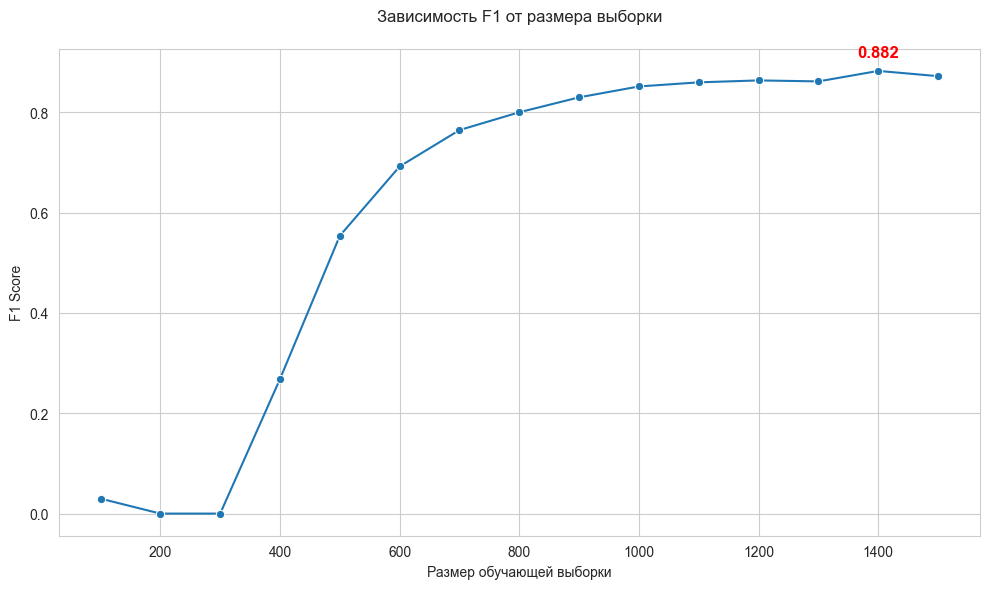


Финальный оставшийся датасет сохранен в remaining_dataset_final.csv
Размер финального датасета: 2543 сообщений


Some weights of BertForTokenClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



NER-модель обучена успешно!

=== Начинаем обучение RE-модели ===

[RE] Этап 1: Подготовка данных
[RE] Используется тренировочный json: PollenNER_TRAIN_1500.json

[RE] Этап 2: Подготовка датасетов

[RE] Статистика распределения классов:
Train (после сэмплирования): Counter({'has_symptom': 1460, 'no_relation': 1176, 'has_medicine': 82})
Test: Counter({'has_symptom': 56, 'no_relation': 41, 'has_medicine': 4})

[RE] Этап 3: Токенизация


Map:   0%|          | 0/2718 [00:00<?, ? examples/s]

Map:   0%|          | 0/101 [00:00<?, ? examples/s]


[RE] Этап 4: Обучение модели


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.837342,0.237792
2,0.825300,0.831652,0.237792
3,0.810200,0.823624,0.237792



RE-модель: Macro F1 = 0.2378
RE-модель сохранена в models/pollen_re_model

[RE] Результаты обучения:
Macro F1 на тесте: 0.2378

[RE] Этап 5: Детальный анализ результатов

[RE] Подробный отчет по целевым классам:
              precision    recall  f1-score   support

 has_symptom     0.5545    1.0000    0.7134        56
has_medicine     0.0000    0.0000    0.0000         4

   micro avg     0.5545    0.9333    0.6957        60
   macro avg     0.2772    0.5000    0.3567        60
weighted avg     0.5175    0.9333    0.6658        60


=== Финальное тестирование на тестовых примерах ===

Тестовый пример 1:
Текст: В Московской области у меня началась аллергия на пыльцу березы, потекли глаза, нос, принимаю Зиртек и Назонекс. У ребенка в Новокузнецке чешутся глаза, уши и течет нос, врач прописал Кромогексал, Назонекс в нос. В Санкт-Петербурге началось цветение ольхи, сильная реакция, принимаю Эриус, но глаза все равно слезятся.

Результаты анализа:
TOPONYM: Московскойобласти, Новокузнецке,

In [ ]:
if __name__ == '__main__':
    """
    Основной блок выполнения программы.
    Последовательно запускаем все этапы обработки данных и обучения моделей.
    """
    # ===============================
    # 1. Обучение NER-модели
    # ===============================
    print("\n=== Начинаем обучение NER-модели ===")
    # Запускаем цикл обучения NER с активным обучением
    last_ner_model = run_cycle('dataset_v1.csv', sizes)
    print("\nNER-модель обучена успешно!")

    # ===============================
    # 2. Обучение RE-модели
    # ===============================
    print("\n=== Начинаем обучение RE-модели ===")

    # 2.1. Подготовка данных
    print('\n[RE] Этап 1: Подготовка данных')
    # Ищем последний существующий TRAIN json для обучения
    last_train_json = None
    for size in reversed(sizes):
        candidate = f'PollenNER_TRAIN_{size}.json'
        if os.path.exists(candidate):
            last_train_json = candidate
            break
    if last_train_json is None:
        raise FileNotFoundError('Не найден ни один TRAIN json для RE!')
    print(f'[RE] Используется тренировочный json: {last_train_json}')

    # Парсим разметку из JSON файлов
    train_parsed = parse_labelstudio_json(last_train_json)
    test_parsed = parse_labelstudio_json('PollenNER_TEST.json')

    # 2.2. Подготовка датасетов
    print('\n[RE] Этап 2: Подготовка датасетов')
    # Балансируем классы и применяем oversampling для has_medicine
    re_train, rel_labels = prepare_re_dataset(
        train_parsed,
        relation_labels=RE_RELATION_LABELS,
        max_no_relation_ratio=1,
        oversample_medicine=True
    )
    re_test, _ = prepare_re_dataset(
        test_parsed,
        relation_labels=RE_RELATION_LABELS + ['no_relation'],
        max_no_relation_ratio=1,
        oversample_medicine=False
    )

    # Выводим статистику распределения классов
    print('\n[RE] Статистика распределения классов:')
    print('Train (после сэмплирования):', Counter([ex['relation'] for ex in re_train]))
    print('Test:', Counter([ex['relation'] for ex in re_test]))

    # Создаем словари для преобразования меток
    rel_label2id = {l: i for i, l in enumerate(rel_labels)}
    rel_id2label = {i: l for l, i in rel_label2id.items()}

    # 2.3. Токенизация
    print('\n[RE] Этап 3: Токенизация')
    re_train_ds = prepare_hf_re_dataset(re_train, TOKENIZER, rel_label2id)
    re_test_ds = prepare_hf_re_dataset(re_test, TOKENIZER, rel_label2id)

    # 2.4. Обучение модели
    print('\n[RE] Этап 4: Обучение модели')
    trainer_re, eval_results_re = train_and_eval_re_model(
        train_ds=re_train_ds,
        test_ds=re_test_ds,
        num_labels=len(rel_labels),
        label2id=rel_label2id,
        id2label=rel_id2label,
        tokenizer=TOKENIZER,
        hf_token=HF_TOKEN,
        output_dir='models/pollen_re_model',
        epochs=5
    )
    print(f"\n[RE] Результаты обучения:")
    print(f"Macro F1 на тесте: {eval_results_re['eval_f1']:.4f}")

    # 2.5. Детальный анализ результатов
    print('\n[RE] Этап 5: Детальный анализ результатов')
    # Получаем предсказания для тестового набора
    re_test_preds = trainer_re.predict(re_test_ds)
    y_true = re_test_preds.label_ids
    y_pred = re_test_preds.predictions.argmax(-1)

    # Преобразуем индексы в метки
    y_true_labels = [rel_id2label[i] for i in y_true]
    y_pred_labels = [rel_id2label[i] for i in y_pred]

    # Выводим подробный отчет по целевым классам
    target_labels = [l for l in rel_labels if l != 'no_relation']
    print("\n[RE] Подробный отчет по целевым классам:")
    print(classification_report(y_true_labels, y_pred_labels, labels=target_labels, digits=4, zero_division=0))


    # ===============================
    # 3. Финальное тестирование
    # ===============================
    print('\n=== Финальное тестирование на тестовых примерах ===')
    for i, text in enumerate(TEST_EXAMPLES, 1):
        print(f'\nТестовый пример {i}:')
        print(f'Текст: {text}')

        # Извлекаем сущности и отношения
        entities, relations = infer_ner_re_on_text(
            text, last_ner_model, trainer_re.model, TOKENIZER, ID2LABEL, rel_id2label
        )

        # Собираем симптомы из отношений has_symptom
        symptoms_from_relations = []
        for rel in relations:
            if rel['relation'] == 'has_symptom':
                symptoms_from_relations.append(rel['tail']['text'])

        # Группируем сущности по типу (исключая BODY_PART)
        ent_by_type = {label: [] for label in LABELS if label != 'BODY_PART'}
        for ent in entities:
            if ent['label'] in ent_by_type:
                if ent['label'] == 'SYMPTOM':
                    # Для SYMPTOM используем только те, что из has_symptom
                    if ent['text'] in symptoms_from_relations:
                        ent_by_type[ent['label']].append(ent['text'])
                else:
                    # Для остальных сущностей используем все найденные
                    ent_by_type[ent['label']].append(ent['text'])

        # Выводим результаты
        print('\nРезультаты анализа:')
        for label in ent_by_type.keys():
            if ent_by_type[label]:
                ents_str = ', '.join(ent_by_type[label])
                print(f'{label}: {ents_str}')
            else:
                print(f'{label}: не найдено')

## Вывод

Проведённые эксперименты показали, что уже с 500 размеченными сообщениями наблюдался заметный рост F1‑метрики, а к 1400 примерам модель достигла стабильного уровня в 0.882, демонстрируя зрелость и надёжность алгоритма.

Внедрение отдельного модуля для оценки отношений (RE) существенно повысило точность выделения и классификации симптомов, устранив ложные срабатывания на упоминания частей тела.

Интеграция NER и RE модулей в единую NLP‑конвейерную архитектуру позволяет в реальном времени автоматически обрабатывать пользовательские сообщения Пыльца Club, извлекая топонимы, симптомы, препараты и аллергены и устанавливая между ними семантические связи.